In [1]:
# ============================================
# BLOK 1 — STATUS PR25 (FINAL)
# - Hitung status PR25 vs RD23 & OL
# - Tambah OGs & OG_primary untuk dipakai blok 2/3
# - Sanity check pola ID
# ============================================

import os, re, csv
import pandas as pd
from collections import defaultdict

# ---------- 1) KONFIGURASI PATH ----------
OF_ROOT = r"D:\result\output_bio\OF_PR25_RD23_OL_MSA_20250929_141953\Results_Sep29"
PAIR_PR25_RD23 = os.path.join(OF_ROOT, r"Orthologues\Orthologues_PR25\PR25__v__RD23.tsv")
PAIR_PR25_OL   = os.path.join(OF_ROOT, r"Orthologues\Orthologues_PR25\PR25__v__OL.tsv")

OUT_DIR        = r"D:\result\output_bio\tables"
STATUS_TSV     = os.path.join(OUT_DIR, "PR25_status.tsv")

# >>> set ke False untuk MENYIMPAN
PREVIEW_ONLY   = False

# ---------- 2) UTIL PARSER ----------
def parse_pairwise_multi(path, pr25_label="PR25"):
    pr25_to_partners = defaultdict(set)
    pr25_to_og       = defaultdict(set)
    pr25_all_ids     = set()

    if not os.path.exists(path):
        raise FileNotFoundError(f"Tidak ditemukan: {path}")

    with open(path, encoding="utf-8", newline="") as f:
        rdr = csv.reader(f, delimiter="\t")
        header = next(rdr, None)
        if header is None:
            raise ValueError(f"File kosong: {path}")

        og_idx    = header.index("Orthogroup")
        pr25_idx  = header.index(pr25_label)
        partner_idx = [i for i in range(len(header)) if i not in (og_idx, pr25_idx)][0]

        def split_many(cell):
            if not cell: return []
            return [x.strip() for x in cell.split(",") if x.strip()]

        for row in rdr:
            if not row or len(row) <= partner_idx:
                continue
            og = row[og_idx].strip()
            pr25_list    = split_many(row[pr25_idx])
            partner_list = split_many(row[partner_idx])

            for p in pr25_list:
                pr25_all_ids.add(p)
                pr25_to_og[p].add(og)
                for q in partner_list:
                    pr25_to_partners[p].add(q)

    return pr25_to_partners, pr25_to_og, pr25_all_ids

def pick_primary(ogs_set):
    if not ogs_set: 
        return ""
    def og_num(og):
        m = re.match(r"OG0*([0-9]+)$", str(og).strip().upper())
        return int(m.group(1)) if m else 10**9
    return sorted((o.strip().upper() for o in ogs_set), key=og_num)[0]

# ---------- 3) BACA 2 FILE PAIRWISE ----------
rd23_map, rd23_ogs, pr25_from_rd23 = parse_pairwise_multi(PAIR_PR25_RD23, pr25_label="PR25")
ol_map,   ol_ogs,   pr25_from_ol   = parse_pairwise_multi(PAIR_PR25_OL,   pr25_label="PR25")
pr25_all = pr25_from_rd23 | pr25_from_ol

# ---------- 4) SANITY CHECK pola ID ----------
def frac(pattern, ids, limit=3000):
    import itertools
    if not ids: return 0.0
    rgx = re.compile(pattern)
    samp = list(itertools.islice(iter(ids), 0, limit))
    hit = sum(1 for x in samp if rgx.search(str(x)))
    return hit / len(samp)

PR25_LIKE = r"OsZS97_\d+G\d+_\d+"
OL_LIKE   = r"AMDW\d+\.\d+_FG[PT]\d+"

pr25_like = frac(PR25_LIKE, pr25_all)
ol_like   = frac(OL_LIKE,   pr25_all)
print(f"[Sanity] PR25-like fraction di kolom PR25: {pr25_like:.3f}")
print(f"[Sanity]  OL-like fraction di kolom PR25: {ol_like:.3f}")
print("[Info] OrthoFinder memakai nama file FASTA sebagai nama spesies (kolom), "
      "dan ID diambil dari header FASTA; orthogroups/orthologues tersusun per-spesies. ")

# ---------- 5) HITUNG STATUS & RANGKAI TABEL ----------
rows  = []
count = {"RD23_only":0, "OL_only":0, "BOTH":0, "NONE":0}

for pr25 in sorted(pr25_all):
    r_partners = rd23_map.get(pr25, set())
    o_partners = ol_map.get(pr25, set())
    has_r = len(r_partners) > 0
    has_o = len(o_partners) > 0

    if   has_r and has_o: status = "BOTH"
    elif has_r:           status = "RD23_only"
    elif has_o:           status = "OL_only"
    else:                 status = "NONE"
    count[status] += 1

    ogs = (rd23_ogs.get(pr25, set())) | (ol_ogs.get(pr25, set()))
    rows.append({
        "PR25_id":       pr25,
        "status":        status,
        "RD23_partner":  ";".join(sorted(r_partners)),
        "OL_partner":    ";".join(sorted(o_partners)),
        "OGs":           ";".join(sorted(ogs)) if ogs else "",
        "OG_primary":    pick_primary(ogs),
    })

df_status = pd.DataFrame(rows, columns=[
    "PR25_id","status","RD23_partner","OL_partner","OGs","OG_primary"
])

# ---------- 6) PREVIEW / SAVE ----------
print("\n=== RINGKASAN STATUS ===")
for k in ("RD23_only","OL_only","BOTH","NONE"):
    print(f"{k:10s}: {count[k]:,}")

print("\n=== PREVIEW 10 BARIS PERTAMA ===")
print(df_status.head(10).to_string(index=False))

if PREVIEW_ONLY:
    print("\n[NOTE] PREVIEW_ONLY=True → belum menyimpan PR25_status.tsv")
else:
    os.makedirs(OUT_DIR, exist_ok=True)
    df_status.to_csv(STATUS_TSV, sep="\t", index=False)
    print(f"[SAVED] {STATUS_TSV} | rows={len(df_status):,}")

[Sanity] PR25-like fraction di kolom PR25: 0.962
[Sanity]  OL-like fraction di kolom PR25: 0.004
[Info] OrthoFinder memakai nama file FASTA sebagai nama spesies (kolom), dan ID diambil dari header FASTA; orthogroups/orthologues tersusun per-spesies. 

=== RINGKASAN STATUS ===
RD23_only : 19,299
OL_only   : 2,599
BOTH      : 27,293
NONE      : 0

=== PREVIEW 10 BARIS PERTAMA ===
                         PR25_id  status RD23_partner            OL_partner       OGs OG_primary
transcript_AMDW01003051.1_FGT001 OL_only              AMDW01003051.1_FGP001 OG0022160  OG0022160
transcript_AMDW01006991.1_FGT001 OL_only              AMDW01006991.1_FGP001 OG0023769  OG0023769
transcript_AMDW01007179.1_FGT001 OL_only              AMDW01007179.1_FGP001 OG0023339  OG0023339
transcript_AMDW01007359.1_FGT001 OL_only              AMDW01007359.1_FGP001 OG0022024  OG0022024
transcript_AMDW01007556.1_FGT001 OL_only              AMDW01007556.1_FGP001 OG0022246  OG0022246
transcript_AMDW01008042.1_FGT001 OL_o

In [2]:
# ==== BLOK 2 (QC/Preview dengan VALIDASI LENGKAP) ====
import os, re, gzip
from pathlib import Path
import pandas as pd
from collections import defaultdict, Counter

# ----------------- KONFIGURASI PATH -----------------
OUT_DIR     = r"D:\result\output_bio\tables"
STATUS_TSV  = os.path.join(OUT_DIR, "PR25_status.tsv")

OG_FILE     = r"D:\result\output_bio\OF_PR25_RD23_OL_MSA_20250929_141953\Results_Sep29\Orthogroups\Orthogroups.tsv"

PR25_CLEAN  = r"D:\result\output_bio\clean_proteins\PR25.clean.fa"
PR25_ORIG   = r"D:\result\output_bio\proteins\PR25.final.pep.all.fa"
RD23_CLEAN  = r"D:\result\output_bio\clean_proteins\RD23.clean.fa"
RD23_ORIG   = r"D:\result\output_bio\proteins\RD23.final.pep.all.fa"
OL_CLEAN    = r"D:\result\output_bio\clean_proteins\OL.clean.fa"
OL_PUB_PEP  = r"D:\TA1\combined_pep\Oryza_longistaminata.O_longistaminata_v1.0.pep.all.fa"

GENE_TREES_DIR         = r"D:\result\output_bio\OF_PR25_RD23_OL_MSA_20250929_141953\Results_Sep29\Gene_Trees"
RESOLVED_GENE_TREES_DIR= r"D:\result\output_bio\OF_PR25_RD23_OL_MSA_20250929_141953\Results_Sep29\Resolved_Gene_Trees"

# ----------------- PARAMETER TAMPILAN -----------------
PREVIEW_ROWS_STATUS = 5
PREVIEW_IDS_PER_SET = 5
PREVIEW_OG_ROWS     = 5
PREVIEW_HAS_TREE    = 5
PREVIEW_NO_TREE     = 5

# ----------------- UTIL -----------------
def _open(path):
    """Smart file opener untuk .gz dan regular files"""
    if not os.path.exists(path):
        return None
    return gzip.open(path, "rt", encoding="utf-8", errors="ignore") if str(path).lower().endswith(".gz") \
           else open(path, "rt", encoding="utf-8", errors="ignore")

def fasta_ids(path, limit=None):
    """Extract IDs dari file FASTA"""
    ids = []
    f = _open(path)
    if f is None:
        print(f"[WARNING] File tidak dapat dibuka: {path}")
        return ids
    
    with f:
        for ln in f:
            if ln.startswith(">"):
                raw_id = ln[1:].strip().split()[0]
                ids.append(raw_id)
                if limit and len(ids) >= limit:
                    break
    return ids

def check_file_health(path, label):
    """Comprehensive file health check"""
    print(f"\n{'='*60}")
    print(f"FILE HEALTH CHECK: {label}")
    print(f"{'='*60}")
    print(f"Path: {path}")
    
    if not os.path.exists(path):
        print(f"❌ STATUS: File TIDAK DITEMUKAN")
        return False
    
    size_bytes = os.path.getsize(path)
    size_mb = size_bytes / (1024*1024)
    print(f"✓ File exists: {size_mb:.2f} MB ({size_bytes:,} bytes)")
    
    if size_bytes == 0:
        print(f"❌ STATUS: File KOSONG (0 bytes)")
        return False
    
    # Try to read first few lines
    try:
        f = _open(path)
        if f is None:
            print(f"❌ STATUS: File tidak dapat dibuka")
            return False
            
        with f:
            lines = []
            for i, ln in enumerate(f):
                lines.append(ln.strip())
                if i >= 9:  # Read first 10 lines
                    break
            
            if not lines:
                print(f"❌ STATUS: File kosong atau tidak terbaca")
                return False
            
            print(f"✓ Readable: YES")
            print(f"✓ First line: {lines[0][:80]}...")
            
            # Count sequences
            seq_count = sum(1 for ln in lines if ln.startswith(">"))
            print(f"✓ Sequences in first 10 lines: {seq_count}")
            
            if lines[0].startswith(">"):
                print(f"✓ Format: Valid FASTA")
            else:
                print(f"⚠ Format: May not be FASTA (doesn't start with '>')")
            
            return True
            
    except Exception as e:
        print(f"❌ ERROR reading file: {e}")
        return False

def quick_check_pair(A, B, label, show_dupe=True):
    """Compare two FASTA files with detailed stats"""
    print(f"\n{'='*70}")
    print(f"PAIRWISE COMPARISON: {label}")
    print(f"{'='*70}")
    
    A_ids = fasta_ids(A)
    B_ids = fasta_ids(B)
    setA, setB = set(A_ids), set(B_ids)
    inter = len(setA & setB)
    onlyA = len(setA - setB)
    onlyB = len(setB - setA)
    
    print(f"File A: {os.path.basename(A)}")
    print(f"  Total IDs: {len(A_ids):,}")
    print(f"  Unique IDs: {len(setA):,}")
    
    print(f"\nFile B: {os.path.basename(B)}")
    print(f"  Total IDs: {len(B_ids):,}")
    print(f"  Unique IDs: {len(setB):,}")
    
    print(f"\nSet Operations:")
    print(f"  Intersection (A ∩ B): {inter:,}")
    print(f"  Only in A (A - B): {onlyA:,}")
    print(f"  Only in B (B - A): {onlyB:,}")
    
    if len(setA) > 0:
        overlap_pct = (inter / len(setA)) * 100
        print(f"  Overlap %: {overlap_pct:.2f}%")
    
    # Duplicate check
    if show_dupe:
        ca = Counter(A_ids)
        cb = Counter(B_ids)
        dupeA = [k for k,v in ca.items() if v>1]
        dupeB = [k for k,v in cb.items() if v>1]
        
        print(f"\nDuplicate Check:")
        print(f"  A - Duplicates: {len(dupeA):,} | Max count: {max(ca.values()) if ca else 0}")
        print(f"  B - Duplicates: {len(dupeB):,} | Max count: {max(cb.values()) if cb else 0}")
        
        if dupeA:
            print(f"  A - Examples: {dupeA[:3]}")
        if dupeB:
            print(f"  B - Examples: {dupeB[:3]}")
    
    # Sample IDs
    exA = A_ids[:PREVIEW_IDS_PER_SET]
    exB = B_ids[:PREVIEW_IDS_PER_SET]
    
    print(f"\nSample IDs from A (first {min(len(exA), PREVIEW_IDS_PER_SET)}):")
    for i, id_str in enumerate(exA, 1):
        print(f"  {i}. {id_str}")
    
    print(f"\nSample IDs from B (first {min(len(exB), PREVIEW_IDS_PER_SET)}):")
    for i, id_str in enumerate(exB, 1):
        print(f"  {i}. {id_str}")

# ----------------- MAIN QC WORKFLOW -----------------
print("="*80)
print("BLOK 2 - QUALITY CONTROL & VALIDATION")
print("="*80)

# 1. FILE HEALTH CHECKS
print("\n" + "="*80)
print("SECTION 1: FILE HEALTH CHECKS")
print("="*80)

files_to_check = [
    (PR25_CLEAN, "PR25 Clean FASTA"),
    (PR25_ORIG, "PR25 Original FASTA"),
    (RD23_CLEAN, "RD23 Clean FASTA"),
    (RD23_ORIG, "RD23 Original FASTA"),
    (OL_CLEAN, "OL Clean FASTA"),
    (OL_PUB_PEP, "OL Public PEP FASTA"),
]

file_health_summary = {}
for fpath, flabel in files_to_check:
    is_healthy = check_file_health(fpath, flabel)
    file_health_summary[flabel] = is_healthy

# Summary
print("\n" + "="*80)
print("FILE HEALTH SUMMARY")
print("="*80)
for flabel, is_healthy in file_health_summary.items():
    status = "✓ HEALTHY" if is_healthy else "✗ PROBLEM"
    print(f"{status:12s} | {flabel}")

# 2. PAIRWISE COMPARISONS
print("\n" + "="*80)
print("SECTION 2: PAIRWISE FASTA COMPARISONS")
print("="*80)

quick_check_pair(PR25_CLEAN, PR25_ORIG, "PR25_clean_vs_original")
quick_check_pair(RD23_CLEAN, RD23_ORIG, "RD23_clean_vs_original")
quick_check_pair(OL_CLEAN, OL_PUB_PEP, "OL_clean_vs_public_pep")

# 3. STATUS FILE CHECK
print("\n" + "="*80)
print("SECTION 3: PR25_STATUS.TSV VALIDATION")
print("="*80)

if not os.path.isfile(STATUS_TSV):
    print(f"❌ STATUS_TSV tidak ditemukan: {STATUS_TSV}")
else:
    df_status = pd.read_csv(STATUS_TSV, sep="\t", dtype=str).fillna("")
    print(f"✓ File loaded: {len(df_status):,} rows")
    
    print(f"\n--- Column Information ---")
    print(f"Columns: {list(df_status.columns)}")
    print(f"\n--- First {PREVIEW_ROWS_STATUS} rows ---")
    cols_show = [c for c in ["PR25_id","status","OG_primary","OGs"] if c in df_status.columns]
    print(df_status[cols_show].head(PREVIEW_ROWS_STATUS).to_string(index=False))
    
    print(f"\n--- Status Breakdown ---")
    if "status" in df_status.columns:
        status_counts = df_status["status"].value_counts()
        total = len(df_status)
        for st, cnt in status_counts.items():
            pct = (cnt/total)*100
            print(f"  {st:12s}: {cnt:7,} ({pct:5.2f}%)")
    
    print(f"\n--- OG Coverage ---")
    if "OGs" in df_status.columns:
        with_og = (df_status["OGs"].str.len() > 0).sum()
        pct = (with_og/len(df_status))*100
        print(f"  Rows with OGs: {with_og:,} / {len(df_status):,} ({pct:.2f}%)")

# 4. ORTHOGROUPS FILE CHECK
print("\n" + "="*80)
print("SECTION 4: ORTHOGROUPS FILE VALIDATION")
print("="*80)

if not os.path.isfile(OG_FILE):
    print(f"❌ Orthogroups file tidak ditemukan: {OG_FILE}")
else:
    sep = "\t" if OG_FILE.lower().endswith(".tsv") else ","
    df_og = pd.read_csv(OG_FILE, sep=sep, dtype=str).fillna("")
    
    print(f"✓ File loaded: {len(df_og):,} orthogroups")
    print(f"✓ Columns: {list(df_og.columns)}")
    
    # Detect species columns
    col_pr25 = next((c for c in df_og.columns if c.upper().startswith("PR25")), None)
    col_rd23 = next((c for c in df_og.columns if c.upper().startswith("RD23")), None)
    col_ol   = next((c for c in df_og.columns if c.upper().startswith("OL")),   None)
    
    print(f"\n--- Species Columns Detected ---")
    print(f"  PR25: {col_pr25}")
    print(f"  RD23: {col_rd23}")
    print(f"  OL: {col_ol}")
    
    # PR25-only orthogroups
    if all([col_pr25, col_rd23, col_ol]):
        def nonempty(x): return bool(str(x).strip())
        mask_pr25_only = df_og[col_pr25].map(nonempty) & ~df_og[col_rd23].map(nonempty) & ~df_og[col_ol].map(nonempty)
        n_pr25_only = mask_pr25_only.sum()
        
        print(f"\n--- PR25-only Orthogroups ---")
        print(f"  Count: {n_pr25_only:,}")
        
        if n_pr25_only > 0:
            df_po = df_og.loc[mask_pr25_only, ["Orthogroup", col_pr25]].head(PREVIEW_OG_ROWS).copy()
            df_po.rename(columns={col_pr25:"PR25_ids"}, inplace=True)
            
            # Show with member count
            def count_members(s):
                parts = [p.strip() for p in str(s).split(",") if p.strip()]
                return f"({len(parts)} members)"
            
            df_po["Count"] = df_po["PR25_ids"].map(count_members)
            print(f"\n  First {PREVIEW_OG_ROWS} PR25-only OGs:")
            print(df_po[["Orthogroup", "Count"]].to_string(index=False))

# 5. GENE TREES SCAN
print("\n" + "="*80)
print("SECTION 5: GENE TREES AVAILABILITY")
print("="*80)

og_pat = re.compile(r"^(OG\d{7})_tree\.txt$", re.IGNORECASE)

def scan_tree_dir(dir_path, tree_map):
    """Scan directory for tree files"""
    dirp = Path(dir_path)
    print(f"\nScanning: {dir_path}")
    print(f"  Exists: {dirp.exists()}")
    
    if not dirp.exists():
        return 0
    
    count = 0
    for p in dirp.iterdir():
        if p.is_file():
            m = og_pat.match(p.name)
            if m:
                og = m.group(1).upper()
                if og not in tree_map:
                    tree_map[og] = str(p)
                    count += 1
    
    print(f"  Tree files found: {count:,}")
    print(f"  Total OGs indexed: {len(tree_map):,}")
    return count

tree_map = {}
resolved_count = scan_tree_dir(RESOLVED_GENE_TREES_DIR, tree_map)
regular_count = scan_tree_dir(GENE_TREES_DIR, tree_map)

print(f"\n--- Tree Summary ---")
print(f"  Resolved trees: {resolved_count:,}")
print(f"  Regular trees: {regular_count:,}")
print(f"  Total unique OGs with trees: {len(tree_map):,}")

# Sample tree paths
print(f"\n  Sample tree paths (first 3):")
for i, (og, path) in enumerate(list(tree_map.items())[:3], 1):
    print(f"    {i}. {og}: {path}")

# 6. FINAL RECOMMENDATIONS
print("\n" + "="*80)
print("SECTION 6: RECOMMENDATIONS FOR BLOK 3")
print("="*80)

issues = []
warnings = []

# Check file health
if not file_health_summary.get("PR25 Original FASTA", False):
    issues.append("PR25 Original FASTA bermasalah - pastikan file ada dan readable")
if not file_health_summary.get("RD23 Original FASTA", False):
    issues.append("RD23 Original FASTA bermasalah - pastikan file ada dan readable")

# Check if clean files have content
pr25_clean_ids = fasta_ids(PR25_CLEAN, limit=1)
rd23_clean_ids = fasta_ids(RD23_CLEAN, limit=1)
ol_clean_ids = fasta_ids(OL_CLEAN, limit=1)

if not pr25_clean_ids:
    issues.append("PR25 Clean FASTA kosong atau tidak terbaca")
if not rd23_clean_ids:
    issues.append("RD23 Clean FASTA kosong atau tidak terbaca")
if not ol_clean_ids:
    issues.append("OL Clean FASTA kosong atau tidak terbaca")

if issues:
    print("\n❌ CRITICAL ISSUES DETECTED:")
    for i, issue in enumerate(issues, 1):
        print(f"  {i}. {issue}")
else:
    print("\n✓ No critical issues detected")

if warnings:
    print("\n⚠ WARNINGS:")
    for i, warn in enumerate(warnings, 1):
        print(f"  {i}. {warn}")

print("\n--- Next Steps ---")
print("1. Jika ada CRITICAL ISSUES, perbaiki file-file tersebut dulu")
print("2. Jika semua OK, lanjut ke BLOK 3 FINAL")
print("3. BLOK 3 akan gunakan GFF mapping untuk ID conversion")
print("4. Annotation akan di-merge dari PR25, RD23, dan OL")

print("\n" + "="*80)
print("BLOK 2 QC SELESAI")
print("="*80)

BLOK 2 - QUALITY CONTROL & VALIDATION

SECTION 1: FILE HEALTH CHECKS

FILE HEALTH CHECK: PR25 Clean FASTA
Path: D:\result\output_bio\clean_proteins\PR25.clean.fa
✓ File exists: 21.41 MB (22,454,352 bytes)
✓ Readable: YES
✓ First line: >transcript:OsZS97_11G024900_01...
✓ Sequences in first 10 lines: 1
✓ Format: Valid FASTA

FILE HEALTH CHECK: PR25 Original FASTA
Path: D:\result\output_bio\proteins\PR25.final.pep.all.fa
✓ File exists: 21.48 MB (22,520,913 bytes)
✓ Readable: YES
✓ First line: >transcript:OsZS97_11G024900_01...
✓ Sequences in first 10 lines: 1
✓ Format: Valid FASTA

FILE HEALTH CHECK: RD23 Clean FASTA
Path: D:\result\output_bio\clean_proteins\RD23.clean.fa
✓ File exists: 21.11 MB (22,137,237 bytes)
✓ Readable: YES
✓ First line: >transcript:OsZS97_11G014200_01...
✓ Sequences in first 10 lines: 1
✓ Format: Valid FASTA

FILE HEALTH CHECK: RD23 Original FASTA
Path: D:\result\output_bio\proteins\RD23.final.pep.all.fa
✓ File exists: 21.14 MB (22,169,701 bytes)
✓ Readable: YES
✓

BLOK 3 FINAL RESMI - ID MAPPING, ANOTASI, & FUNGSI (EggNOG + InterProScan)
MODE: Auto-save ke D:\result\output_bio (tabel utama + tabel unknown/known)

STEP 1: BUILD ID MAPPING (FASTA → NEW IDs)

Processing PR25...
  FASTA IDs found: 52,209
  Sample FASTA IDs:
    1. transcript:OsZS97_11G024900_01
    2. transcript:OsZS97_11G024900_02
    3. transcript:OsZS97_11G024900_03
  Mapped genes   : 34,776
  Old ID variants: 148,284
  Transcript map : 49,428
  Unmapped IDs   : 2,781
  Sample mappings:
    1. PR25gChr11G024900 ← ['transcript:OsZS97_11G024900_04', 'OsZS97-11G024900-02']
    2. PR25gChr11G024890 ← ['OsZS97-11G024890-01', 'OsZS97_11G024890_01']
    3. PR25gChr11G024880 ← ['transcript:OsZS97_11G024880_01', 'OsZS97_11G024880_01']

Processing RD23...
  FASTA IDs found: 49,849
  Sample FASTA IDs:
    1. transcript:OsZS97_11G014200_01
    2. transcript:OsZS97_01G035470_01
    3. transcript:OsZS97_01G035500_01
  Mapped genes   : 35,015
  Old ID variants: 149,547
  Transcript map : 49,849

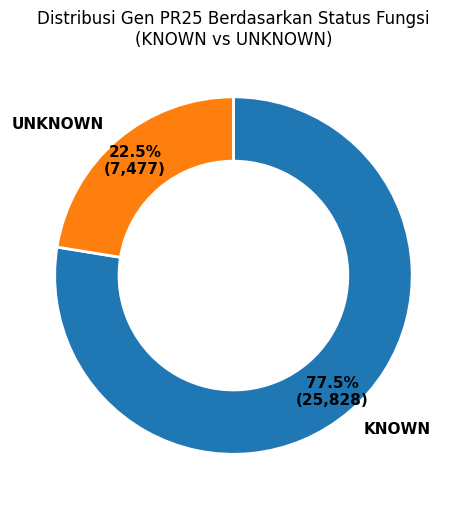

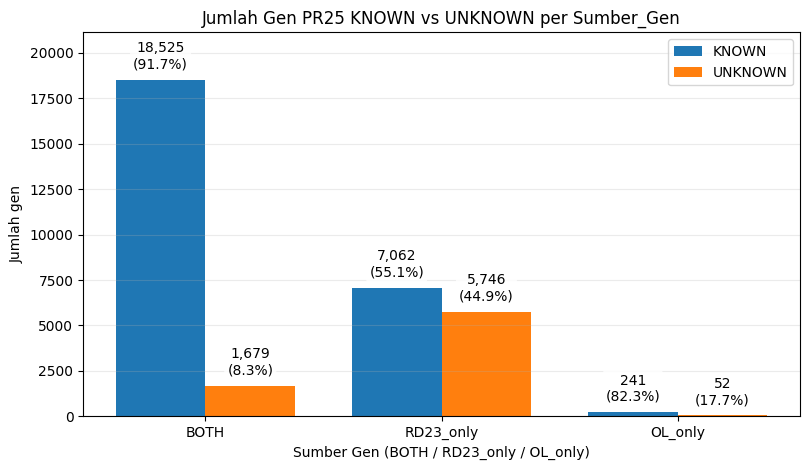


AUTO-SAVE OUTPUT FILES
Tabel TA (ringkas, semua gen)             disimpan ke : D:\result\output_bio\PR25_Final_Table_for_TA.tsv
Tabel full anotasi (df_final, resmi)      disimpan ke : D:\result\output_bio\PR25_Full_Annotation_df_final.tsv
Tabel gen dengan fungsi UNKNOWN saja      disimpan ke : D:\result\output_bio\PR25_Final_Table_for_TA_Unknown_Only.tsv
Tabel gen dengan fungsi FUNGSIONAL saja   disimpan ke : D:\result\output_bio\PR25_Final_Table_for_TA_Functional_Only.tsv
Tabel Excel KNOWN/UNKNOWN                 disimpan ke : D:\result\output_bio\figures_block3\known_unknown_tables
Gambar KNOWN/UNKNOWN (donut & barplot) hanya ditampilkan di layar.

BLOK 3 FINAL RESMI (TANPA COG) COMPLETE!

Variabel tersimpan:
  - df_final                   : Full annotation data (EggNOG + InterPro + GO + KEGG + Pfam)
  - final_table_clean          : Tabel format TA (fungsi & anotasi resmi + Status_Fungsi)
  - final_table_unknown_only   : Hanya gen dengan Status_Fungsi = 'UNKNOWN'
  - final_table_fun

In [2]:
# ============================================================================
# BLOK 3 FINAL RESMI (VERSI TANPA COG) - FIX VISUALISASI DONUT (NO GREY BOX)
# ID MAPPING, ANOTASI, & FUNGSI (EggNOG + InterProScan)
# ============================================================================
# Versi ini:
#  - Murni memakai output:
#       * OrthoFinder   → status asal gen (BOTH / RD23_only / OL_only) + partner
#       * EggNOG-mapper → deskripsi fungsi, GO, KEGG, dll.
#       * InterProScan  → domain & deskripsi, GO, Pfam, dll.
#  - TIDAK memakai kategori COG eksternal (tidak pakai cog-24.fun.tab.txt).
#  - Output utama:
#       * PR25_Final_Table_for_TA.tsv              (tabel ringkas + Fungsi_Utama + Status_Fungsi)
#       * PR25_Full_Annotation_df_final.tsv        (anotasi lengkap)
#       * PR25_Final_Table_for_TA_Unknown_Only.tsv
#       * PR25_Final_Table_for_TA_Functional_Only.tsv
#  - Klasifikasi KNOWN vs UNKNOWN:
#       * UNKNOWN jika Fungsi_EggNOG dan Fungsi_InterPro sama-sama unknown
#       * KNOWN   jika minimal salah satu sumber (EggNOG atau InterPro) bukan unknown
#    Logika ini konsisten dengan kodingan BLOK 4 yang digunakan sebelumnya.
# ============================================================================

import os, re, csv, gzip
from pathlib import Path
from typing import Optional, List
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("="*80)
print("BLOK 3 FINAL RESMI - ID MAPPING, ANOTASI, & FUNGSI (EggNOG + InterProScan)")
print("MODE: Auto-save ke D:\\result\\output_bio (tabel utama + tabel unknown/known)")
print("="*80)

# ============================================================================
# KONFIGURASI PATH
# ============================================================================
ROOT_OF = r"D:\result\output_bio\OF_PR25_RD23_OL_MSA_20250929_141953\Results_Sep29"
ORTHO_PR25_RD23 = os.path.join(ROOT_OF, r"Orthologues\Orthologues_PR25\PR25__v__RD23.tsv")
ORTHO_PR25_OL   = os.path.join(ROOT_OF, r"Orthologues\Orthologues_PR25\PR25__v__OL.tsv")

PR25_CLEAN = r"D:\result\output_bio\clean_proteins\PR25.clean.fa"
RD23_CLEAN = r"D:\result\output_bio\clean_proteins\RD23.clean.fa"
OL_CLEAN   = r"D:\result\output_bio\clean_proteins\OL.clean.fa"

GFF_PR25 = r"D:\result\output_bio\liftoff\PR25.final_ZS97_backbone_plus_OLunique.gff3"
GFF_RD23 = r"D:\result\output_bio\liftoff\RD23.from_ZS97.gff3"

EGG_PR25 = r"D:\result\output_bio\eggnog_mapper\PR25_clean_Job MM_dmqb1fu0\MM_dmqb1fu0.emapper.annotations.tsv"
EGG_RD23 = r"D:\result\output_bio\eggnog_mapper\RD23_clean_Job MM_i2mbrg08\MM_i2mbrg08.emapper.annotations.tsv"
EGG_OL   = r"D:\result\output_bio\eggnog_mapper\OL_clean_Job MM_6ei85p_d\MM_6ei85p_d.emapper.annotations.tsv"

IPR_PR25 = r"D:\result\output_bio\out_interproscan\PR25.clean\Galaxy227-[InterProScan on data 184 (tsv)].tabular"
IPR_RD23 = r"D:\result\output_bio\out_interproscan\RD23.clean\Galaxy214-[InterProScan on data 204 (tsv)].tabular"
IPR_OL   = r"D:\result\output_bio\out_interproscan\Oryza longistaminata.pep.all\Galaxy223-[InterProScan on data 218 (tsv)].tabular"

OUTPUT_ROOT = r"D:\result\output_bio"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Folder khusus gambar BLOK 3
FIG_DIR = os.path.join(OUTPUT_ROOT, "figures_block3")
os.makedirs(FIG_DIR, exist_ok=True)

# Folder khusus tabel KNOWN/UNKNOWN (Excel)
KNOWN_DIR = os.path.join(FIG_DIR, "known_unknown_tables")
os.makedirs(KNOWN_DIR, exist_ok=True)

# Gambar: True = simpan; False = hanya tampil
SAVE_FIG = False

# ============================================================================
# HELPER UMUM
# ============================================================================
NULL_TOKENS = {"", "-", "NA", "N/A", "None", "null", "."}

def _clean(x):
    s = str(x).strip()
    return "" if s in NULL_TOKENS else s

def _split_tokens(x):
    if not x:
        return []
    return [t for t in re.split(r"[;\s|,]+", str(x)) if t and t not in NULL_TOKENS]

def _open(path):
    if not os.path.exists(path):
        return None
    if str(path).lower().endswith(".gz"):
        return gzip.open(path, "rt", encoding="utf-8", errors="ignore")
    return open(path, "rt", encoding="utf-8", errors="ignore")

def fmt_int(n: int) -> str:
    return f"{int(n):,}"

def safe_to_excel(df: pd.DataFrame, path: str) -> None:
    try:
        df.to_excel(path, index=False)
        print(f"  Berkas Excel tersimpan : {path}")
    except PermissionError:
        print("  Peringatan: berkas tidak dapat ditulis (kemungkinan sedang dibuka):")
        print(f"             {path}")

# ============================================================================
# FUNGSI: EKSTRAK ID FASTA & KONVERSI ID (PR25/RD23/OL)
# ============================================================================
def extract_fasta_ids(fasta_path: str) -> List[str]:
    ids = []
    f = _open(fasta_path)
    if f is None:
        print(f"[WARNING] Cannot open: {fasta_path}")
        return ids
    with f:
        for line in f:
            if line.startswith(">"):
                raw_id = line[1:].strip().split()[0]
                ids.append(raw_id)
    return ids

ID_PAT_ZS97 = re.compile(r"OsZS97_(\d{2})G(\d{5,6})(?:_(\d{2}))?")

def extract_zs97_core(id_str: str) -> Optional[str]:
    m = ID_PAT_ZS97.search(str(id_str))
    if m:
        return m.group(0)
    return None

def zs97_to_new_gene(tag: str, zs97_id: str) -> Optional[str]:
    m = ID_PAT_ZS97.search(zs97_id)
    if not m:
        return None
    chr_num = m.group(1)
    gene_num = m.group(2)
    return f"{tag}gChr{chr_num}G{gene_num}"

def zs97_to_new_transcript(tag: str, zs97_id: str) -> Optional[str]:
    m = ID_PAT_ZS97.search(zs97_id)
    if not m:
        return None
    chr_num = m.group(1)
    gene_num = m.group(2)
    iso = m.group(3) or "01"
    return f"{tag}gChr{chr_num}G{gene_num}.{int(iso)}"

# ============================================================================
# STEP 1: BUILD ID MAPPING
# ============================================================================
print("\n" + "="*80)
print("STEP 1: BUILD ID MAPPING (FASTA → NEW IDs)")
print("="*80)

def build_comprehensive_mapping(fasta_path: str, tag: str, gff_path: str = None):
    print(f"\nProcessing {tag}...")
    fasta_ids = extract_fasta_ids(fasta_path)
    print(f"  FASTA IDs found: {len(fasta_ids):,}")
    if not fasta_ids:
        print(f"  [ERROR] No IDs extracted from {fasta_path}")
        return {}, {}, {}
    print("  Sample FASTA IDs:")
    for i, fid in enumerate(fasta_ids[:3], 1):
        print(f"    {i}. {fid}")

    old_to_new = {}
    new_to_olds = defaultdict(set)
    transcript_map = {}
    unmapped_count = 0

    # OL: ID dibiarkan apa adanya (1:1 dengan FASTA IDs)
    if tag == "OL":
        for fasta_id in fasta_ids:
            new_gene = fasta_id
            old_to_new[fasta_id] = new_gene
            new_to_olds[new_gene].add(fasta_id)
            transcript_map[fasta_id] = fasta_id

        print(f"  Mapped genes (1:1 dengan FASTA IDs): {len(new_to_olds):,}")
        print(f"  Old ID variants                    : {len(old_to_new):,}")
        print(f"  Transcript map                     : {len(transcript_map):,}")
        print("  Unmapped IDs: 0")
        print("  Sample mappings:")
        for i, (new_gene, old_ids) in enumerate(list(new_to_olds.items())[:3], 1):
            sample_olds = list(old_ids)[:2]
            print(f"    {i}. {new_gene} ← {sample_olds}")
        return old_to_new, new_to_olds, transcript_map

    # PR25 & RD23: pola ZS97 → PR25gChrXXGYYYYY / RD23gChrXXGYYYYY
    for fasta_id in fasta_ids:
        zs97_core = extract_zs97_core(fasta_id)

        if not zs97_core:
            unmapped_count += 1
            continue

        new_gene = zs97_to_new_gene(tag, zs97_core)
        new_transcript = zs97_to_new_transcript(tag, zs97_core)
        if not new_gene:
            unmapped_count += 1
            continue

        variants = [
            fasta_id,
            zs97_core,
            fasta_id.replace("transcript:", "").replace("transcript_", ""),
            zs97_core.replace("_", "-"),
        ]
        for variant in variants:
            if variant:
                old_to_new[variant] = new_gene
                new_to_olds[new_gene].add(variant)

        transcript_map[fasta_id] = new_transcript

    print(f"  Mapped genes   : {len(new_to_olds):,}")
    print(f"  Old ID variants: {len(old_to_new):,}")
    print(f"  Transcript map : {len(transcript_map):,}")
    if unmapped_count > 0:
        print(f"  Unmapped IDs   : {unmapped_count:,}")

    print("  Sample mappings:")
    for i, (new_gene, old_ids) in enumerate(list(new_to_olds.items())[:3], 1):
        sample_olds = list(old_ids)[:2]
        print(f"    {i}. {new_gene} ← {sample_olds}")

    return old_to_new, new_to_olds, transcript_map

pr25_old_to_new, pr25_new_to_olds, pr25_transcript_map = build_comprehensive_mapping(
    PR25_CLEAN, "PR25", GFF_PR25
)
rd23_old_to_new, rd23_new_to_olds, rd23_transcript_map = build_comprehensive_mapping(
    RD23_CLEAN, "RD23", GFF_RD23
)
ol_old_to_new, ol_new_to_olds, ol_transcript_map = build_comprehensive_mapping(
    OL_CLEAN, "OL"
)

# ============================================================================
# STEP 2: PARSE ORTHOLOGUES
# ============================================================================
print("\n" + "="*80)
print("STEP 2: PARSE ORTHOLOGUES & CONVERT TO NEW IDs")
print("="*80)

def parse_orthologues_with_mapping(ortho_path: str, pr25_old_to_new: dict,
                                   partner_old_to_new: dict, partner_name: str):
    pr25_gene_to_partners = defaultdict(set)
    pr25_gene_to_ogs = defaultdict(set)

    if not os.path.exists(ortho_path):
        print(f"[WARNING] File not found: {ortho_path}")
        return pr25_gene_to_partners, pr25_gene_to_ogs

    with open(ortho_path, encoding="utf-8", newline="") as f:
        rdr = csv.reader(f, delimiter="\t")
        header = next(rdr, None)
        if not header:
            return pr25_gene_to_partners, pr25_gene_to_ogs

        og_idx = header.index("Orthogroup")
        pr25_idx = header.index("PR25")
        partner_idx = [i for i in range(len(header)) if i not in (og_idx, pr25_idx)][0]

        def split_members(cell):
            if not cell:
                return []
            return [x.strip() for x in cell.split(",") if x.strip()]

        unmapped_pr25 = 0
        unmapped_partner = 0

        for row in rdr:
            if not row or len(row) <= partner_idx:
                continue

            og = row[og_idx].strip()
            pr25_ids_old = split_members(row[pr25_idx])
            partner_ids_old = split_members(row[partner_idx])

            pr25_genes_new = set()
            for old_id in pr25_ids_old:
                new_gene = pr25_old_to_new.get(old_id)
                if new_gene:
                    pr25_genes_new.add(new_gene)
                else:
                    zs97 = extract_zs97_core(old_id)
                    if zs97:
                        new_gene = zs97_to_new_gene("PR25", zs97)
                        if new_gene:
                            pr25_genes_new.add(new_gene)
                        else:
                            unmapped_pr25 += 1
                    else:
                        unmapped_pr25 += 1

            partner_genes_new = set()
            for old_id in partner_ids_old:
                new_gene = partner_old_to_new.get(old_id)
                if new_gene:
                    partner_genes_new.add(new_gene)
                else:
                    if partner_name == "RD23":
                        zs97 = extract_zs97_core(old_id)
                        if zs97:
                            new_gene = zs97_to_new_gene("RD23", zs97)
                            if new_gene:
                                partner_genes_new.add(new_gene)
                            else:
                                unmapped_partner += 1
                        else:
                            unmapped_partner += 1
                    else:
                        partner_genes_new.add(old_id)

            for pr25_gene in pr25_genes_new:
                pr25_gene_to_ogs[pr25_gene].add(og)
                for partner_gene in partner_genes_new:
                    pr25_gene_to_partners[pr25_gene].add(partner_gene)

        print(f"\n{partner_name} orthologues:")
        print(f"  PR25 genes   : {len(pr25_gene_to_ogs):,}")
        print(f"  Unmapped PR25: {unmapped_pr25:,}")
        print(f"  Unmapped {partner_name}: {unmapped_partner:,}")

    return pr25_gene_to_partners, pr25_gene_to_ogs

rd23_partners, rd23_ogs = parse_orthologues_with_mapping(
    ORTHO_PR25_RD23, pr25_old_to_new, rd23_old_to_new, "RD23"
)
ol_partners, ol_ogs = parse_orthologues_with_mapping(
    ORTHO_PR25_OL, pr25_old_to_new, ol_old_to_new, "OL"
)

all_pr25_genes = set(rd23_ogs.keys()) | set(ol_ogs.keys())
print(f"\nJumlah PR25 genes unik dalam orthologues: {len(all_pr25_genes):,}")

# ============================================================================
# STEP 3: BACA EggNOG & InterProScan (SEMUA SPESIES)
# ============================================================================
print("\n" + "="*80)
print("STEP 3: BUILD ANNOTATION INDICES (EggNOG + InterProScan)")
print("="*80)

def read_eggnog(tsv_path):
    if not os.path.exists(tsv_path):
        return pd.DataFrame(columns=[
            "query", "description", "gos",
            "kegg_ko", "kegg_pathway", "cog_category"
        ])

    with open(tsv_path, encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n") for ln in f if ln.strip()]

    hdr_idx = None
    for i, ln in enumerate(lines):
        if ln.lower().startswith("#query"):
            hdr_idx = i
            break

    if hdr_idx is None:
        return pd.DataFrame(columns=[
            "query", "description", "gos",
            "kegg_ko", "kegg_pathway", "cog_category"
        ])

    cols = lines[hdr_idx].lstrip("#").split("\t")
    rows = [ln.split("\t") for ln in lines[hdr_idx + 1:] if not ln.startswith("#")]

    df = pd.DataFrame(rows, columns=cols).fillna("")
    df.columns = [c.strip().lower() for c in df.columns]

    for c in ["query", "description", "gos", "kegg_ko", "kegg_pathway", "cog_category"]:
        if c not in df.columns:
            df[c] = ""

    keep = ["query", "description", "gos", "kegg_ko", "kegg_pathway", "cog_category"]
    return df[keep].copy()

def read_interpro(ipr_tsv, max_lines=None):
    FUNCTIONAL_DB = {"pfam", "panther", "smart", "gene3d", "superfamily", "tigrfam"}
    SKIP_DB = {"phobius", "tmhmm", "mobidblite", "coils", "signalp"}

    if not os.path.exists(ipr_tsv):
        return pd.DataFrame(columns=["query", "ipr_descs", "pfams", "gos", "ipr_accs"])

    rows = []
    line_count = 0

    with open(ipr_tsv, 'r', encoding='utf-8', errors='ignore') as f:
        for ln in f:
            line_count += 1
            if max_lines and line_count > max_lines:
                break
            if not ln.strip() or ln.startswith("#"):
                continue

            parts = ln.rstrip("\n").split("\t")
            if len(parts) < 13:
                continue
            while len(parts) < 16:
                parts.append("")

            acc = parts[0].strip()
            anal = parts[3].strip().lower()
            sig_a = parts[4].strip()
            sig_d = parts[5].strip()
            ipr_acc = parts[11].strip()
            ipr_d = parts[12].strip()

            if anal in SKIP_DB or (not ipr_acc and anal not in FUNCTIONAL_DB):
                continue

            go_tokens = []
            if len(parts) > 13 and "GO:" in parts[13]:
                go_tokens = [t for t in re.split(r"[,\s;|]+", parts[13]) if t.startswith("GO:")]

            go_str = ";".join(sorted(set(go_tokens))) if go_tokens else ""
            picked_desc = ipr_d if _clean(ipr_d) else sig_d

            if _clean(picked_desc):
                rows.append((acc, anal, sig_a, picked_desc, go_str, ipr_acc))

    if not rows:
        return pd.DataFrame(columns=["query", "ipr_descs", "pfams", "gos", "ipr_accs"])

    df = pd.DataFrame(rows, columns=["query", "analysis", "signature", "ipr_desc", "gos", "ipr_acc"])
    df["pfam"] = df.apply(lambda r: r["signature"] if r["analysis"] == "pfam" else "", axis=1)

    agg = df.groupby("query", sort=False).agg({
        "ipr_desc": lambda s: " | ".join(sorted(list(set([_clean(x) for x in s if _clean(x)])))[:5]),
        "pfam": lambda s: ";".join(sorted(list(set([_clean(x) for x in s if _clean(x)])))),
        "gos": lambda s: ";".join(sorted(set(_split_tokens(";".join([_clean(x) for x in s]))))),
        "ipr_acc": lambda s: ";".join(sorted(list(set([_clean(x) for x in s if _clean(x)]))))
    }).reset_index().rename(columns={"ipr_desc": "ipr_descs", "pfam": "pfams", "ipr_acc": "ipr_accs"})

    return agg[["query", "ipr_descs", "pfams", "gos", "ipr_accs"]]

print("\nReading EggNOG...")
egg_pr25 = read_eggnog(EGG_PR25)
egg_rd23 = read_eggnog(EGG_RD23)
egg_ol   = read_eggnog(EGG_OL)
print(f"  PR25: {len(egg_pr25):,} | RD23: {len(egg_rd23):,} | OL: {len(egg_ol):,}")

print("\nReading InterProScan...")
ipr_pr25 = read_interpro(IPR_PR25, max_lines=500000)
ipr_rd23 = read_interpro(IPR_RD23)
ipr_ol   = read_interpro(IPR_OL)
print(f"  PR25: {len(ipr_pr25):,} | RD23: {len(ipr_rd23):,} | OL: {len(ipr_ol):,}")

# ============================================================================
# STEP 4: BUILD REVERSE LOOKUP UNTUK ANOTASI
# ============================================================================
print("\n" + "="*80)
print("STEP 4: BUILD REVERSE LOOKUP FOR ANNOTATION")
print("="*80)

def build_annotation_index(annot_df, new_to_olds_map, tag):
    index = defaultdict(list)
    old_id_to_annot = {}
    for _, row in annot_df.iterrows():
        query = str(row["query"]).strip()
        old_id_to_annot[query] = row.to_dict()

    print(f"\n{tag} annotation index:")
    print(f"  Annotation records: {len(old_id_to_annot):,}")

    for new_gene, old_ids in new_to_olds_map.items():
        for old_id in old_ids:
            if old_id in old_id_to_annot:
                index[new_gene].append(old_id_to_annot[old_id])
                break

    print(f"  New genes matched: {len(index):,}")
    if len(new_to_olds_map) > 0:
        print(f"  Match rate      : {len(index)/len(new_to_olds_map)*100:.1f}%")

    return index

idx_egg_pr25 = build_annotation_index(egg_pr25, pr25_new_to_olds, "PR25 EggNOG")
idx_egg_rd23 = build_annotation_index(egg_rd23, rd23_new_to_olds, "RD23 EggNOG")
idx_egg_ol   = build_annotation_index(egg_ol,   ol_new_to_olds,   "OL EggNOG")

idx_ipr_pr25 = build_annotation_index(ipr_pr25, pr25_new_to_olds, "PR25 InterPro")
idx_ipr_rd23 = build_annotation_index(ipr_rd23, rd23_new_to_olds, "RD23 InterPro")
idx_ipr_ol   = build_annotation_index(ipr_ol,   ol_new_to_olds,   "OL InterPro")

# ============================================================================
# STEP 5: MERGE ANNOTASI PER GEN PR25
# ============================================================================
print("\n" + "="*80)
print("STEP 5: MERGE ANNOTATIONS FOR EACH PR25 GENE")
print("="*80)

def get_best_description(records):
    if not records:
        return ""
    best = max(records, key=lambda r: len(_clean(r.get("description", ""))))
    return _clean(best.get("description", ""))

def merge_go_terms_from_strings(*go_lists):
    all_gos = set()
    for go_list in go_lists:
        all_gos.update(_split_tokens(go_list))
    return ";".join(sorted(all_gos))

def merge_interpro(ipr_records):
    all_descs = set()
    all_pfams = set()
    all_gos = set()
    all_iprs = set()

    for rec in ipr_records:
        desc = _clean(rec.get("ipr_descs", ""))
        if desc:
            all_descs.add(desc)
        all_pfams.update(_split_tokens(rec.get("pfams", "")))
        all_gos.update(_split_tokens(rec.get("gos", "")))
        all_iprs.update(_split_tokens(rec.get("ipr_accs", "")))

    return all_descs, all_pfams, all_gos, all_iprs

print("\nProcessing genes...")
rows = []

for pr25_gene in sorted(all_pr25_genes):
    has_rd23 = pr25_gene in rd23_partners and len(rd23_partners[pr25_gene]) > 0
    has_ol   = pr25_gene in ol_partners   and len(ol_partners[pr25_gene])   > 0

    if has_rd23 and has_ol:
        status = "BOTH"
    elif has_rd23:
        status = "RD23_only"
    elif has_ol:
        status = "OL_only"
    else:
        status = "NONE"

    rd23_list = sorted(rd23_partners.get(pr25_gene, []))
    ol_list   = sorted(ol_partners.get(pr25_gene, []))

    pr25_egg = idx_egg_pr25.get(pr25_gene, [])
    rd23_egg = []
    for rd23_gene in rd23_list:
        rd23_egg.extend(idx_egg_rd23.get(rd23_gene, []))
    ol_egg = []
    for ol_gene in ol_list:
        ol_egg.extend(idx_egg_ol.get(ol_gene, []))

    pr25_ipr = idx_ipr_pr25.get(pr25_gene, [])
    rd23_ipr = []
    for rd23_gene in rd23_list:
        rd23_ipr.extend(idx_ipr_rd23.get(rd23_gene, []))
    ol_ipr = []
    for ol_gene in ol_list:
        ol_ipr.extend(idx_ipr_ol.get(ol_gene, []))

    eggnog_desc, eggnog_source = "", ""
    if pr25_egg:
        eggnog_desc = get_best_description(pr25_egg)
        eggnog_source = "PR25"
    elif rd23_egg:
        eggnog_desc = get_best_description(rd23_egg)
        eggnog_source = "RD23"
    elif ol_egg:
        eggnog_desc = get_best_description(ol_egg)
        eggnog_source = "OL"

    pr25_ipr_descs, pr25_pfams, pr25_gos, pr25_iprs = merge_interpro(pr25_ipr)
    rd23_ipr_descs, rd23_pfams, rd23_gos, rd23_iprs = merge_interpro(rd23_ipr)
    ol_ipr_descs,   ol_pfams,   ol_gos,   ol_iprs   = merge_interpro(ol_ipr)

    interpro_desc, interpro_source = "", ""
    if pr25_ipr_descs:
        interpro_desc = " | ".join(sorted(list(pr25_ipr_descs))[:3])
        interpro_source = "PR25"
    elif rd23_ipr_descs:
        interpro_desc = " | ".join(sorted(list(rd23_ipr_descs))[:3])
        interpro_source = "RD23"
    elif ol_ipr_descs:
        interpro_desc = " | ".join(sorted(list(ol_ipr_descs))[:3])
        interpro_source = "OL"

    all_gos_egg = []
    for rec in pr25_egg + rd23_egg + ol_egg:
        all_gos_egg.append(rec.get("gos", ""))

    gos_final = merge_go_terms_from_strings(
        *all_gos_egg,
        ";".join(sorted(pr25_gos)),
        ";".join(sorted(rd23_gos)),
        ";".join(sorted(ol_gos))
    )

    ko_final = ""
    pathway_final = ""
    for rec in pr25_egg + rd23_egg + ol_egg:
        if not ko_final and _clean(rec.get("kegg_ko", "")):
            ko_final = _clean(rec.get("kegg_ko", ""))
        if not pathway_final and _clean(rec.get("kegg_pathway", "")):
            pathway_final = _clean(rec.get("kegg_pathway", ""))

    all_ipr_descs = " | ".join(sorted(list(pr25_ipr_descs | rd23_ipr_descs | ol_ipr_descs)))
    all_pfams = ";".join(sorted(list(pr25_pfams | rd23_pfams | ol_pfams)))

    rows.append({
        "PR25_gene": pr25_gene,
        "gene_status": status,
        "RD23_partners": ";".join(rd23_list),
        "OL_partners": ";".join(ol_list),
        "N_RD23": len(rd23_list),
        "N_OL": len(ol_list),
        "EggNOG_desc": eggnog_desc,
        "EggNOG_source": eggnog_source,
        "InterPro_desc": interpro_desc,
        "InterPro_source": interpro_source,
        "GOs": gos_final,
        "KEGG_KO": ko_final,
        "KEGG_pathway": pathway_final,
        "InterPro_full": all_ipr_descs,
        "Pfam": all_pfams
    })

df_final = pd.DataFrame(rows)

# ============================================================================
# STEP 6: TABEL TA (RINGKAS) + FUNGSI UTAMA (LOGIKA SEPERTI BLOK 4)
# ============================================================================
print("\n" + "="*80)
print("STEP 6: CREATE FINAL TABLE FOR TA (RESMI, TANPA COG)")
print("="*80)

final_table_ta = df_final[[
    'PR25_gene','gene_status','RD23_partners','OL_partners',
    'EggNOG_desc','InterPro_desc','GOs','KEGG_KO','Pfam'
]].copy()

final_table_ta.columns = [
    'Gen_PR25','Sumber_Gen','Partner_RD23','Partner_OL',
    'Fungsi_EggNOG','Fungsi_InterPro','GO_Terms','KEGG_Orthology','Pfam_Domains'
]

final_table_ta = final_table_ta.fillna('')
final_table_ta = final_table_ta.replace('-', '')

UNK_KEYWORDS = [
    "uncharacterized","uncharacterised","unknown function",
    "protein of unknown function","domain of unknown function",
    "hypothetical protein"
]

def is_unknown_desc(text: str) -> bool:
    if pd.isna(text):
        return True
    t = str(text).strip().lower()
    if t == "":
        return True
    if t in {"unknown", "unknown function"}:
        return True
    return any(k in t for k in UNK_KEYWORDS)

final_table_ta["is_unknown_EggNOG"]   = final_table_ta["Fungsi_EggNOG"].apply(is_unknown_desc)
final_table_ta["is_unknown_InterPro"] = final_table_ta["Fungsi_InterPro"].apply(is_unknown_desc)
final_table_ta["is_known_Fungsi_EggNOG"]   = ~final_table_ta["is_unknown_EggNOG"]
final_table_ta["is_known_Fungsi_InterPro"] = ~final_table_ta["is_unknown_InterPro"]

def pilih_fungsi_utama(row) -> str:
    fe = row.get("Fungsi_EggNOG", "")
    fi = row.get("Fungsi_InterPro", "")
    unk_fe = row.get("is_unknown_EggNOG", True)
    unk_fi = row.get("is_unknown_InterPro", True)

    fe_str = "" if pd.isna(fe) else str(fe).strip()
    fi_str = "" if pd.isna(fi) else str(fi).strip()

    if (not unk_fe) and fe_str:
        return fe_str
    if (not unk_fi) and fi_str:
        return fi_str
    if fe_str:
        return fe_str
    if fi_str:
        return fi_str
    return ""

def susun_fungsi_kombinasi(row) -> str:
    fe = row.get("Fungsi_EggNOG", "")
    fi = row.get("Fungsi_InterPro", "")
    fe_str = "" if pd.isna(fe) else str(fe).strip()
    fi_str = "" if pd.isna(fi) else str(fi).strip()

    parts = []
    if fe_str and fe_str.lower() != "nan":
        parts.append(fe_str)
    if fi_str and fi_str.lower() != "nan":
        if fi_str not in parts:
            parts.append(fi_str)
    return " | ".join(parts)

final_table_ta["Fungsi_Utama"]     = final_table_ta.apply(pilih_fungsi_utama, axis=1)
final_table_ta["Fungsi_Kombinasi"] = final_table_ta.apply(susun_fungsi_kombinasi, axis=1)

final_table_ta["is_unknown_Fungsi_Utama"] = final_table_ta["Fungsi_Utama"].apply(is_unknown_desc)
final_table_ta["is_known_Fungsi_Utama"]   = ~final_table_ta["is_unknown_Fungsi_Utama"]

final_table_ta["Status_Fungsi"] = np.where(
    final_table_ta["is_unknown_EggNOG"] & final_table_ta["is_unknown_InterPro"],
    "UNKNOWN",
    "KNOWN"
)

final_table_clean = final_table_ta[[
    'Gen_PR25','Sumber_Gen','Partner_RD23','Partner_OL',
    'Fungsi_Utama','GO_Terms','KEGG_Orthology','Pfam_Domains',
    'Fungsi_EggNOG','Fungsi_InterPro','Fungsi_Kombinasi',
    'Status_Fungsi','is_known_Fungsi_Utama','is_known_Fungsi_EggNOG','is_known_Fungsi_InterPro'
]].copy()

print(f"\nFinal TA table created: {len(final_table_clean):,} genes")

# ============================================================================
# STEP 6b: RINGKASAN OUTPUT (LOG)
# ============================================================================
print("\n" + "="*80)
print("RESULTS (RINGKASAN RESMI)")
print("="*80)

total_genes = len(final_table_clean)
print(f"Total PR25 genes in final_table_clean : {total_genes:,}")

print("\nStatus breakdown (Sumber_Gen):")
status_counts = final_table_clean["Sumber_Gen"].value_counts()
for st, ct in status_counts.items():
    pct = ct / total_genes * 100 if total_genes > 0 else 0.0
    print(f"  {st:12s}: {ct:7,} ({pct:5.2f}%)")

mask_known   = final_table_clean["Status_Fungsi"] == "KNOWN"
mask_unknown = final_table_clean["Status_Fungsi"] == "UNKNOWN"

n_known = int(mask_known.sum())
n_unknown = int(mask_unknown.sum())

pct_known = n_known / total_genes * 100 if total_genes > 0 else 0.0
pct_unknown = n_unknown / total_genes * 100 if total_genes > 0 else 0.0

print("\nFungsi (Status_Fungsi berbasis kombinasi EggNOG + InterPro):")
print(f"  Gen dengan fungsi KNOWN   : {n_known:7,} ({pct_known:5.1f}%)")
print(f"  Gen dengan fungsi UNKNOWN : {n_unknown:7,} ({pct_unknown:5.1f}%)")

summary_ku = (
    final_table_clean
    .groupby(["Sumber_Gen", "Status_Fungsi"])
    .size()
    .unstack(fill_value=0)
)
summary_ku["total"] = summary_ku.sum(axis=1)
summary_ku["pct_known"]   = summary_ku.get("KNOWN", 0)   / summary_ku["total"] * 100
summary_ku["pct_unknown"] = summary_ku.get("UNKNOWN", 0) / summary_ku["total"] * 100

print("\nRingkasan KNOWN/UNKNOWN per Sumber_Gen:")
print(summary_ku)

# ============================================================================
# STEP 7: SUMMARY UNKNOWN vs FUNCTIONAL (UNTUK FILE TERPISAH)
# ============================================================================
print("\n" + "="*80)
print("STEP 7: SUMMARY UNKNOWN vs FUNCTIONAL (RESMI)")
print("="*80)

final_table_unknown_only    = final_table_clean[mask_unknown].copy()
final_table_functional_only = final_table_clean[mask_known].copy()

print(f"Total gen PR25 dalam tabel TA : {total_genes:,}")
print(f"  Gen dengan fungsi KNOWN (punya fungsi) : {len(final_table_functional_only):7,}")
print(f"  Gen dengan fungsi UNKNOWN              : {len(final_table_unknown_only):7,}")

def export_known_unknown(df_in: pd.DataFrame, known_flag_col: str, label: str):
    df_known   = df_in[df_in[known_flag_col]].copy()
    df_unknown = df_in[~df_in[known_flag_col]].copy()

    n_total   = len(df_in)
    n_k       = len(df_known)
    n_u       = len(df_unknown)

    summary = pd.DataFrame({
        "label":[label], "total":[n_total], "known":[n_k], "unknown":[n_u],
        "pct_known":[100.0*n_k/n_total if n_total else 0.0],
        "pct_unknown":[100.0*n_u/n_total if n_total else 0.0]
    })

    path_known   = os.path.join(KNOWN_DIR, f"Block3_{label}_KNOWN_only_vFix.xlsx")
    path_unknown = os.path.join(KNOWN_DIR, f"Block3_{label}_UNKNOWN_only_vFix.xlsx")

    print(f"- {label}: total={n_total:,}, known={n_k:,}, unknown={n_u:,}")
    safe_to_excel(df_known, path_known)
    safe_to_excel(df_unknown, path_unknown)
    return summary

summary_fu  = export_known_unknown(final_table_clean, "is_known_Fungsi_Utama",   "FungsiUtama")
summary_egg = export_known_unknown(final_table_clean, "is_known_Fungsi_EggNOG",  "EggNOG")
summary_ipr = export_known_unknown(final_table_clean, "is_known_Fungsi_InterPro","InterPro")

summary_all = pd.concat([summary_fu, summary_egg, summary_ipr], ignore_index=True)
summary_path = os.path.join(KNOWN_DIR, "Block3_Summary_KNOWN_UNKNOWN_vFix.xlsx")
safe_to_excel(summary_all, summary_path)

print("\nRingkasan KNOWN/UNKNOWN per definisi:")
print(summary_all)

# ============================================================================
# STEP 8: VISUALISASI KNOWN vs UNKNOWN (RAPI FIX v3 - NO GREY BOX)
#   - Donut: rounded white box transparan + posisi rapi + garis tepi putih
#   - Barplot: matplotlib grouped bars + headroom + label rapi
# ============================================================================
print("\n" + "="*80)
print("STEP 8: VISUALISASI KNOWN vs UNKNOWN (RAPI FIX v3)")
print("="*80)

def plot_donut_known_unknown(df_in: pd.DataFrame, status_col: str = "Status_Fungsi"):
    counts = df_in[status_col].value_counts()
    known_ct = int(counts.get("KNOWN", 0))
    unknown_ct = int(counts.get("UNKNOWN", 0))

    labels = ["KNOWN", "UNKNOWN"]
    values = np.array([known_ct, unknown_ct], dtype=float)
    total = float(values.sum())

    def autopct_fmt(pct):
        n = int(round(pct / 100.0 * total))
        return f"{pct:.1f}%\n({fmt_int(n)})"

    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    wedges, texts, autotexts = ax.pie(
        values,
        labels=labels,              # label KNOWN/UNKNOWN muncul
        startangle=90,
        counterclock=False,

        # angka dipaksa masuk ke ring donut
        autopct=autopct_fmt,
        pctdistance=0.85,           # (kunci) besarkan -> angka makin masuk ring

        # label agak keluar supaya tidak tabrakan angka
        labeldistance=1.12,

        wedgeprops=dict(width=0.36, edgecolor="white", linewidth=2),
        textprops=dict(fontsize=11)
    )

    # inner radius = 1 - width = 0.64
    ax.add_artist(plt.Circle((0, 0), 0.64, fc="white"))

    # hilangkan kotak pada angka (autopct)
    for t in autotexts:
        t.set_bbox(None)            # penting: tidak ada kotak
        t.set_color("black")
        t.set_fontweight("bold")
        t.set_ha("center")
        t.set_va("center")

    # (opsional) label sedikit ditebalkan biar jelas
    for t in texts:
        t.set_fontweight("bold")

    ax.set_aspect("equal")
    ax.set_title("Distribusi Gen PR25 Berdasarkan Status Fungsi\n(KNOWN vs UNKNOWN)", fontsize=12)

    plt.tight_layout()

    if SAVE_FIG:
        out_donut = os.path.join(FIG_DIR, "B3_donut_KNOWN_UNKNOWN_allgenes.png")
        fig.savefig(out_donut, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"Gambar donut disimpan ke : {out_donut}")
    else:
        plt.show()

def plot_bar_known_unknown_by_source(df_in: pd.DataFrame,
                                     status_col: str = "Status_Fungsi",
                                     source_col: str = "Sumber_Gen"):

    order_sources = ["BOTH", "RD23_only", "OL_only"]
    tmp = (
        df_in.groupby([source_col, status_col])
             .size()
             .unstack(fill_value=0)
    )
    if "KNOWN" not in tmp.columns: tmp["KNOWN"] = 0
    if "UNKNOWN" not in tmp.columns: tmp["UNKNOWN"] = 0

    idx = [x for x in order_sources if x in tmp.index] + [x for x in tmp.index if x not in order_sources]
    tmp = tmp.loc[idx].copy()

    totals = tmp["KNOWN"] + tmp["UNKNOWN"]
    pct_known = np.where(totals > 0, tmp["KNOWN"] / totals * 100, 0.0)
    pct_unknown = np.where(totals > 0, tmp["UNKNOWN"] / totals * 100, 0.0)

    fig, ax = plt.subplots(figsize=(8.2, 4.8))

    x = np.arange(len(tmp.index))
    w = 0.38

    b1 = ax.bar(x - w/2, tmp["KNOWN"].values, width=w, label="KNOWN")
    b2 = ax.bar(x + w/2, tmp["UNKNOWN"].values, width=w, label="UNKNOWN")

    ax.set_xticks(x)
    ax.set_xticklabels(tmp.index)
    ax.set_xlabel("Sumber Gen (BOTH / RD23_only / OL_only)")
    ax.set_ylabel("Jumlah gen")
    ax.set_title("Jumlah Gen PR25 KNOWN vs UNKNOWN per Sumber_Gen", fontsize=12)
    ax.legend()

    ymax = max(tmp["KNOWN"].max(), tmp["UNKNOWN"].max())
    ax.set_ylim(0, ymax * 1.14)   # headroom supaya label tidak kepotong
    ax.grid(axis="y", alpha=0.25)

    def add_labels(bars, pcts):
        for i, bar in enumerate(bars):
            h = bar.get_height()
            if h <= 0:
                continue
            ax.annotate(
                f"{fmt_int(h)}\n({pcts[i]:.1f}%)",
                (bar.get_x() + bar.get_width()/2, h),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center", va="bottom",
                fontsize=10,
                bbox=dict(
                    boxstyle="round,pad=0.22",
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.85
                )
            )

    add_labels(b1, pct_known)
    add_labels(b2, pct_unknown)

    plt.tight_layout()

    if SAVE_FIG:
        out_bar = os.path.join(FIG_DIR, "B3_bar_KNOWN_UNKNOWN_by_SumberGen.png")
        fig.savefig(out_bar, dpi=300, bbox_inches="tight")
        plt.close(fig)
        print(f"Gambar bar disimpan ke : {out_bar}")
    else:
        plt.show()

# Jalankan visualisasi
plot_donut_known_unknown(final_table_clean)
plot_bar_known_unknown_by_source(final_table_clean)

# ============================================================================
# AUTO-SAVE OUTPUT KE FOLDER
# ============================================================================
output_ta   = os.path.join(OUTPUT_ROOT, "PR25_Final_Table_for_TA.tsv")
output_full = os.path.join(OUTPUT_ROOT, "PR25_Full_Annotation_df_final.tsv")
output_unk  = os.path.join(OUTPUT_ROOT, "PR25_Final_Table_for_TA_Unknown_Only.tsv")
output_fun  = os.path.join(OUTPUT_ROOT, "PR25_Final_Table_for_TA_Functional_Only.tsv")

final_table_clean.to_csv(output_ta,   sep="\t", index=False, encoding='utf-8')
df_final.to_csv(output_full, sep="\t", index=False, encoding='utf-8')
final_table_unknown_only.to_csv(output_unk, sep="\t", index=False, encoding='utf-8')
final_table_functional_only.to_csv(output_fun, sep="\t", index=False, encoding='utf-8')

print("\n" + "="*80)
print("AUTO-SAVE OUTPUT FILES")
print("="*80)
print(f"Tabel TA (ringkas, semua gen)             disimpan ke : {output_ta}")
print(f"Tabel full anotasi (df_final, resmi)      disimpan ke : {output_full}")
print(f"Tabel gen dengan fungsi UNKNOWN saja      disimpan ke : {output_unk}")
print(f"Tabel gen dengan fungsi FUNGSIONAL saja   disimpan ke : {output_fun}")
print(f"Tabel Excel KNOWN/UNKNOWN                 disimpan ke : {KNOWN_DIR}")
if SAVE_FIG:
    print(f"Gambar KNOWN/UNKNOWN (donut & barplot)    disimpan ke : {FIG_DIR}")
else:
    print("Gambar KNOWN/UNKNOWN (donut & barplot) hanya ditampilkan di layar.")

print("\n" + "="*80)
print("BLOK 3 FINAL RESMI (TANPA COG) COMPLETE!")
print("="*80)
print("\nVariabel tersimpan:")
print("  - df_final                   : Full annotation data (EggNOG + InterPro + GO + KEGG + Pfam)")
print("  - final_table_clean          : Tabel format TA (fungsi & anotasi resmi + Status_Fungsi)")
print("  - final_table_unknown_only   : Hanya gen dengan Status_Fungsi = 'UNKNOWN'")
print("  - final_table_functional_only: Hanya gen dengan Status_Fungsi = 'KNOWN'")


BLOK 4 FINAL v21 - VISUALISASI, TOP-10 & FUNGSI DOMINAN PER Sumber_Gen
✓ Data loaded: 33,305 genes

FIGURE 1: Donut Distribusi Gen Turunan (Sumber_Gen)
Sumber_Gen
BOTH         20204
RD23_only    12808
OL_only        293
Name: count, dtype: int64 

  ✓ Saved: D:\result\output_bio\figures_block4\01_donut_SumberGen_v21.png


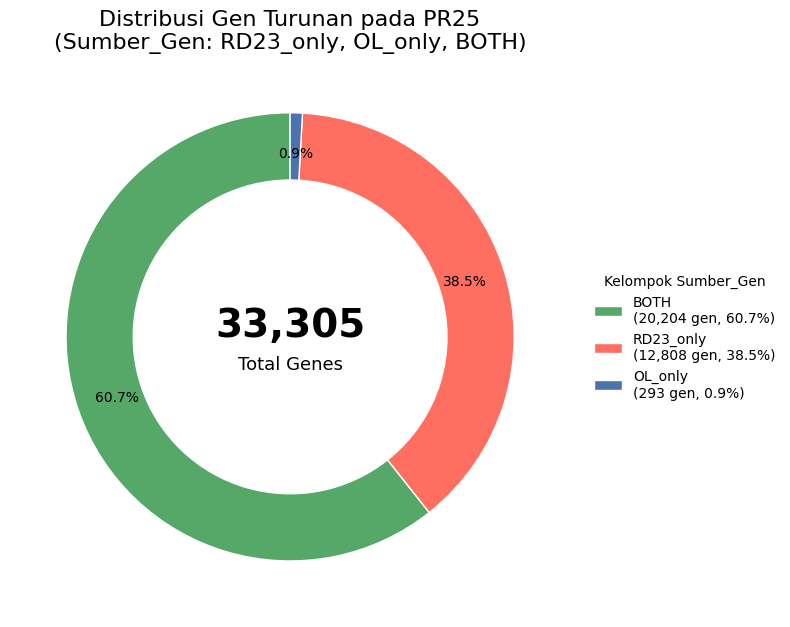

EXPORT 1: Daftar gen per Sumber_Gen ke Excel
✓ Excel EXPORT 1 disimpan ke: D:\result\output_bio\figures_block4\Block4_Genes_by_SumberGen_v21.xlsx

EXPORT 2: Tabel KNOWN/UNKNOWN & ringkasan persen
  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\known_unknown_tables\Block4_FungsiUtama_KNOWN_only_v21.xlsx
  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\known_unknown_tables\Block4_FungsiUtama_UNKNOWN_only_v21.xlsx

Ringkasan KNOWN/UNKNOWN untuk FungsiUtama:
            n_known  n_unknown  total  pct_known  pct_unknown
Sumber_Gen                                                   
BOTH          18525       1679  20204      91.69         8.31
OL_only         241         52    293      82.25        17.75
RD23_only      7062       5746  12808      55.14        44.86 

  ✓ Ringkasan disimpan ke: D:\result\output_bio\figures_block4\known_unknown_tables\Block4_FungsiUtama_KNOWN_UNKNOWN_summary_v21.csv

  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\known_unknown_tabl

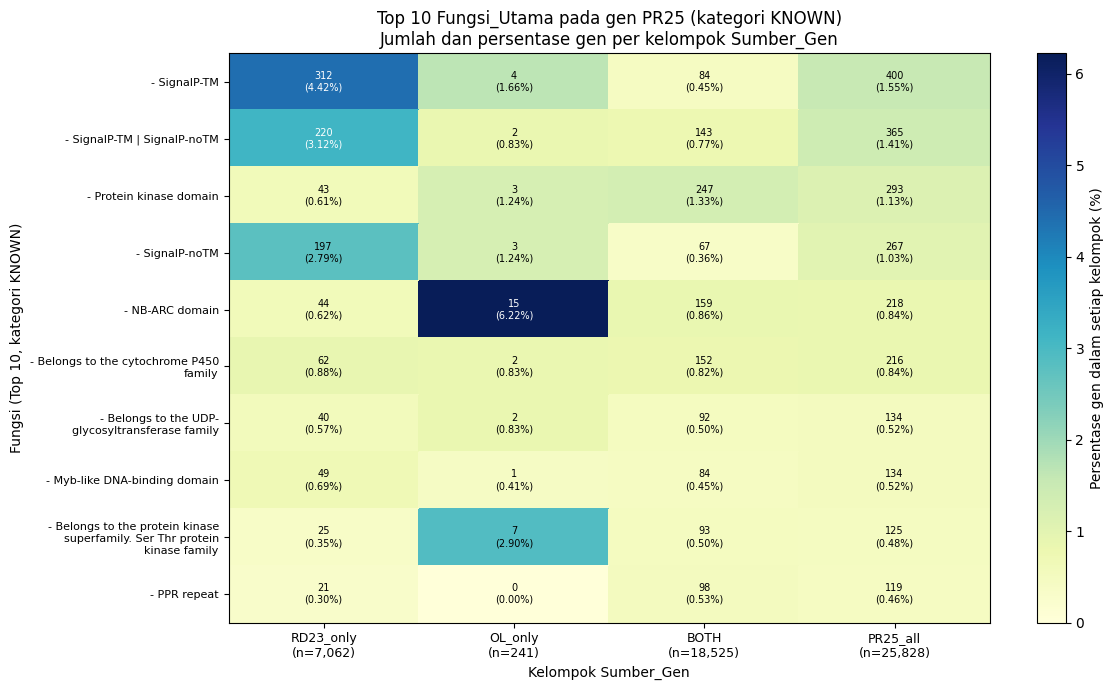

  ✓ Saved: D:\result\output_bio\figures_block4\21_heatmap_Top10_FungsiEggNOG_KNOWN_v21.png


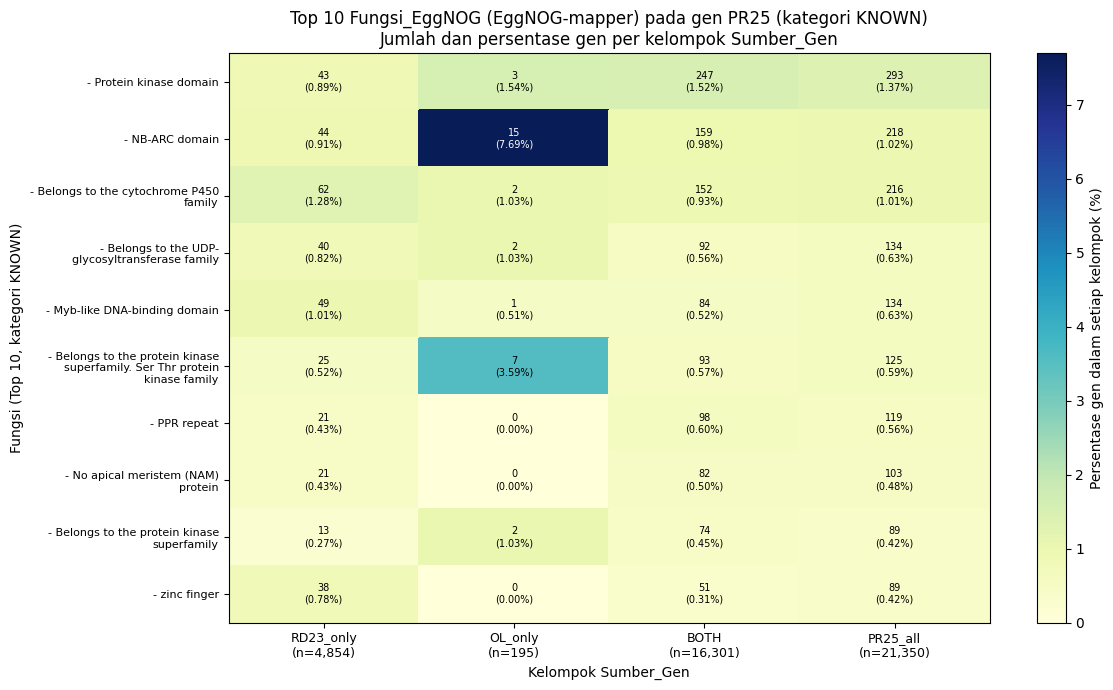

  ✓ Saved: D:\result\output_bio\figures_block4\22_heatmap_Top10_FungsiInterPro_KNOWN_v21.png


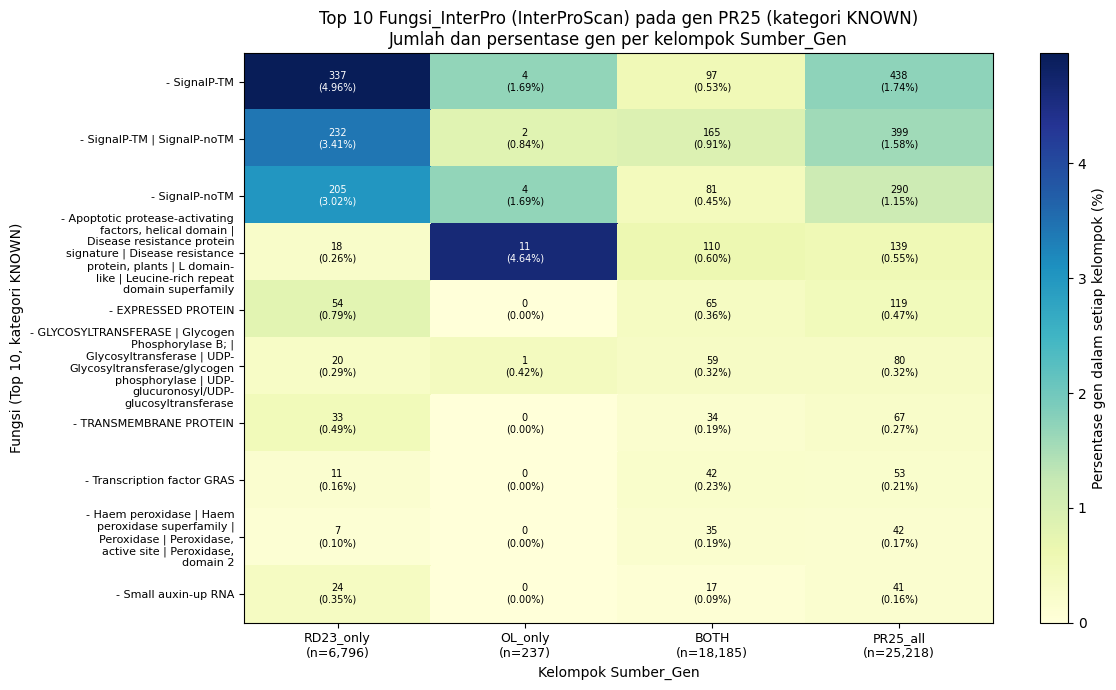

FIGURE: Top-10 per kelompok (kategori KNOWN)
  ✓ Saved: D:\result\output_bio\figures_block4\23_Top10_FungsiUtama_BOTH_v21.png


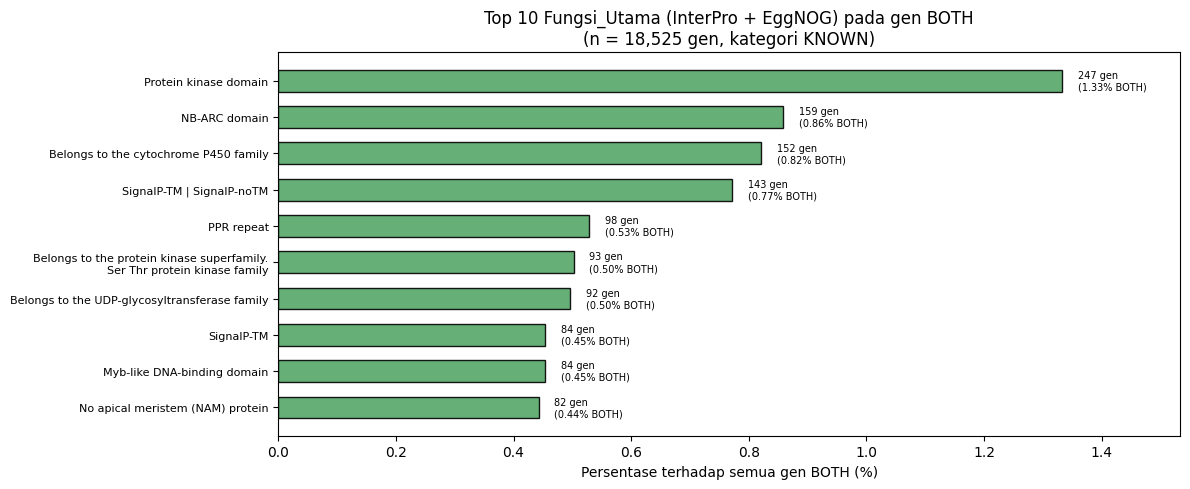

  ✓ Saved: D:\result\output_bio\figures_block4\23_Top10_FungsiUtama_RD23_only_v21.png


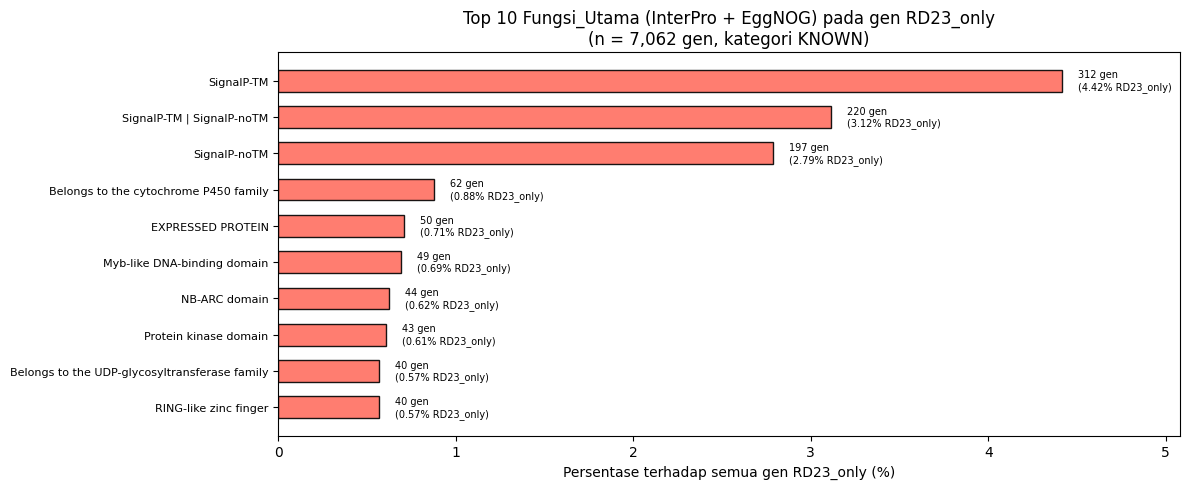

  ✓ Saved: D:\result\output_bio\figures_block4\23_Top10_FungsiUtama_OL_only_v21.png


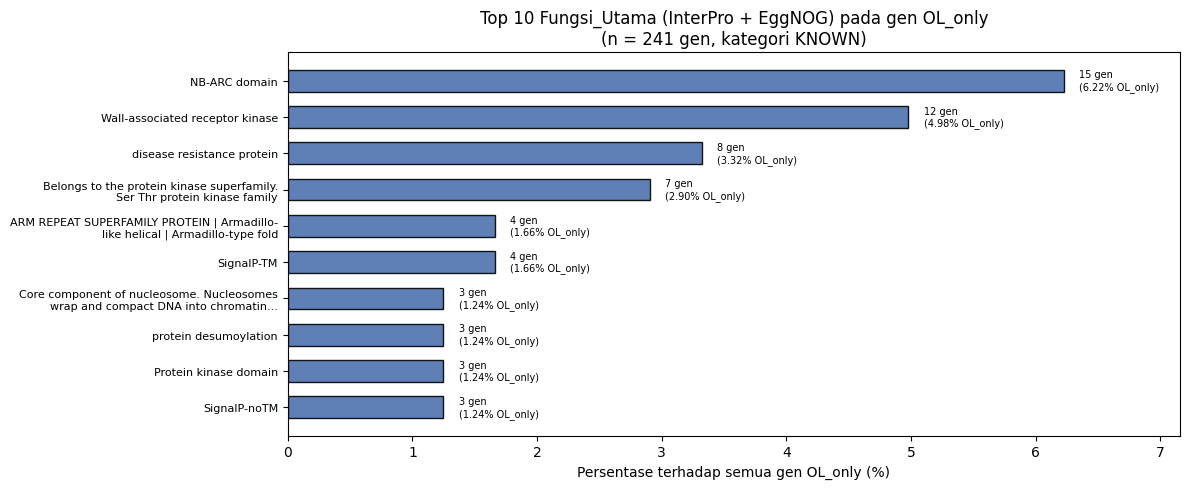

  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\Block4_OL_only_Top10_Fungsi_Utama_KNOWN_Genes_v21.xlsx
  ✓ Saved: D:\result\output_bio\figures_block4\24_Top10_FungsiEggNOG_BOTH_v21.png


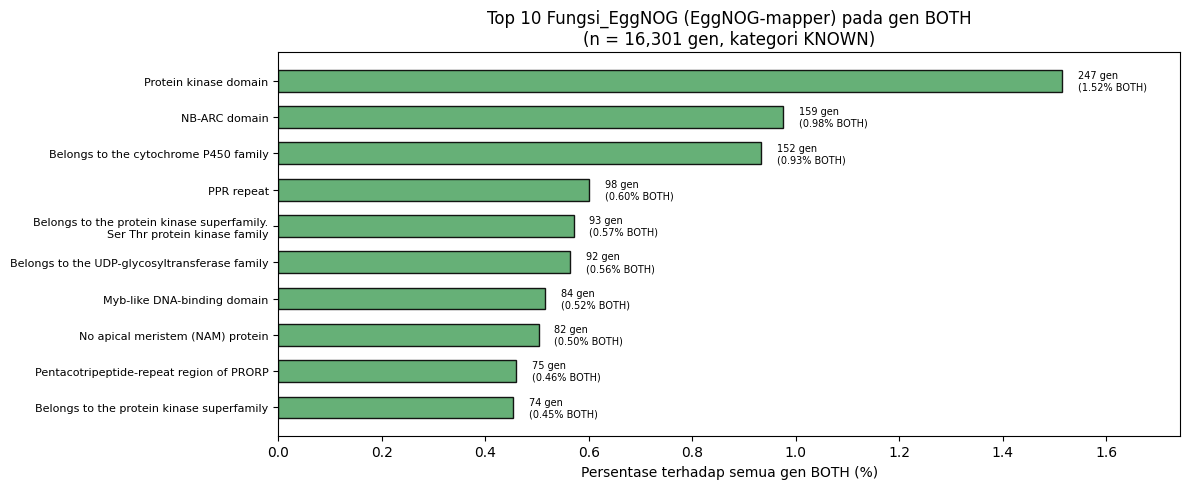

  ✓ Saved: D:\result\output_bio\figures_block4\24_Top10_FungsiEggNOG_RD23_only_v21.png


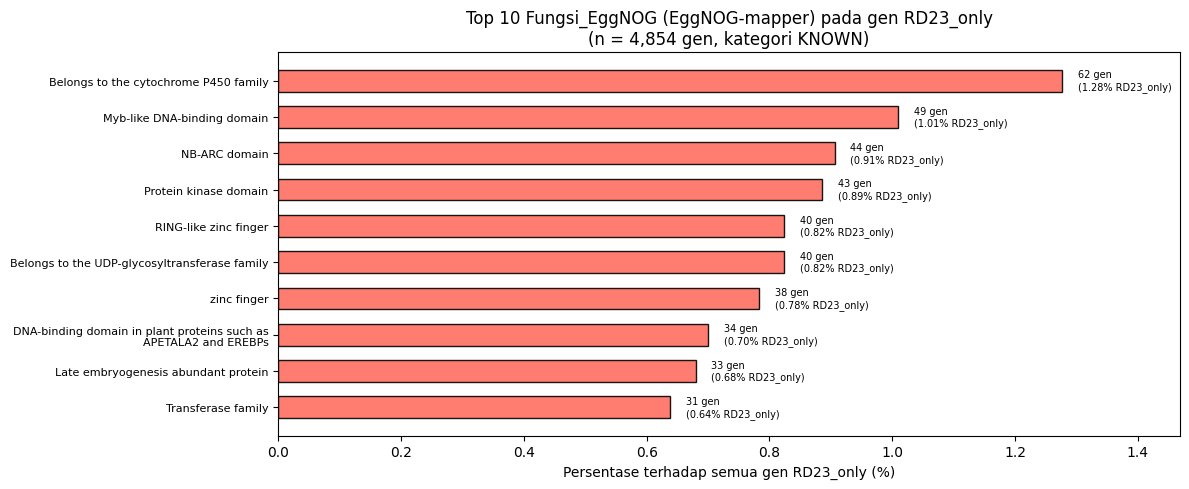

  ✓ Saved: D:\result\output_bio\figures_block4\24_Top10_FungsiEggNOG_OL_only_v21.png


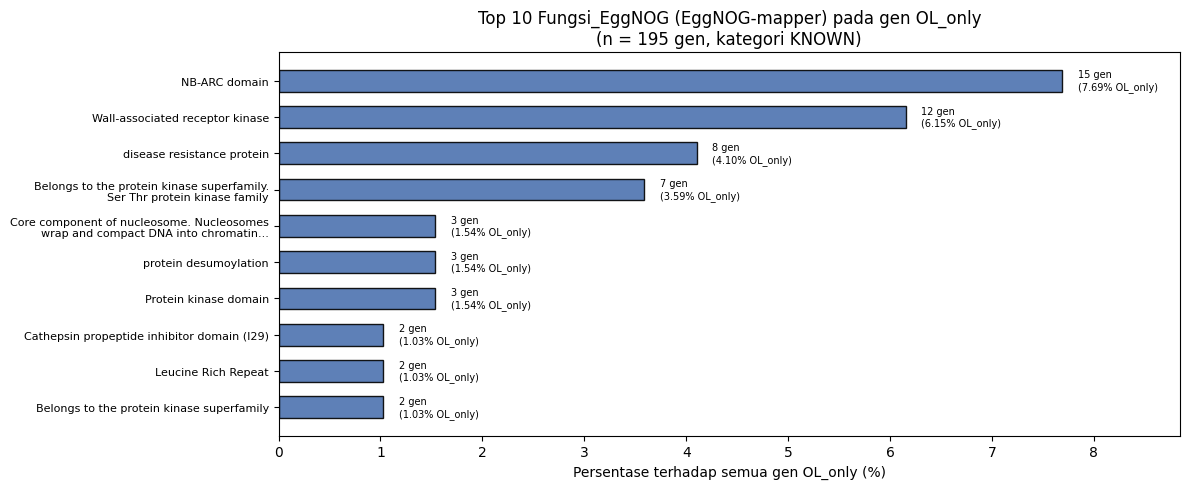

  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\Block4_OL_only_Top10_Fungsi_EggNOG_KNOWN_Genes_v21.xlsx
  ✓ Saved: D:\result\output_bio\figures_block4\25_Top10_FungsiInterPro_BOTH_v21.png


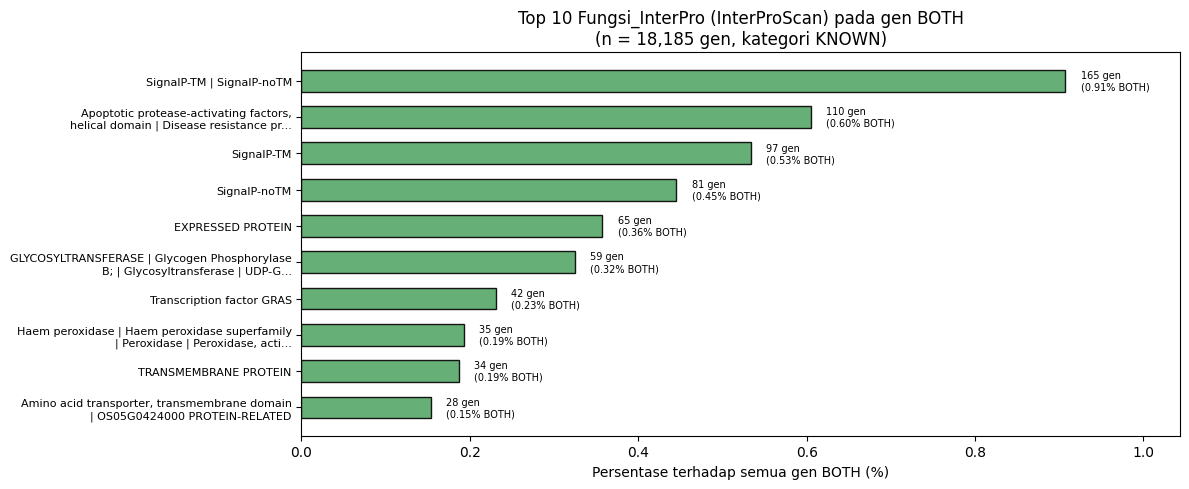

  ✓ Saved: D:\result\output_bio\figures_block4\25_Top10_FungsiInterPro_RD23_only_v21.png


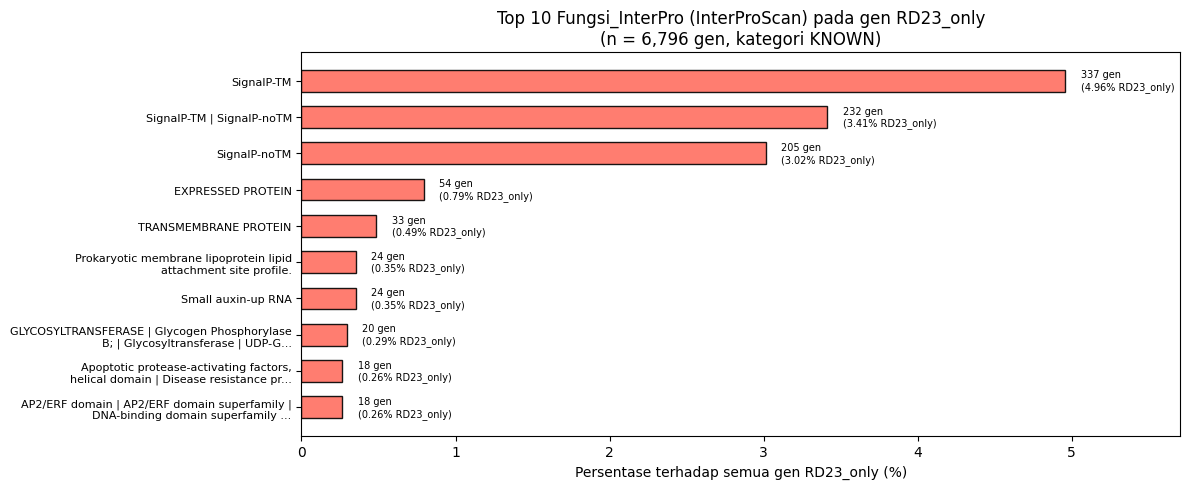

  ✓ Saved: D:\result\output_bio\figures_block4\25_Top10_FungsiInterPro_OL_only_v21.png


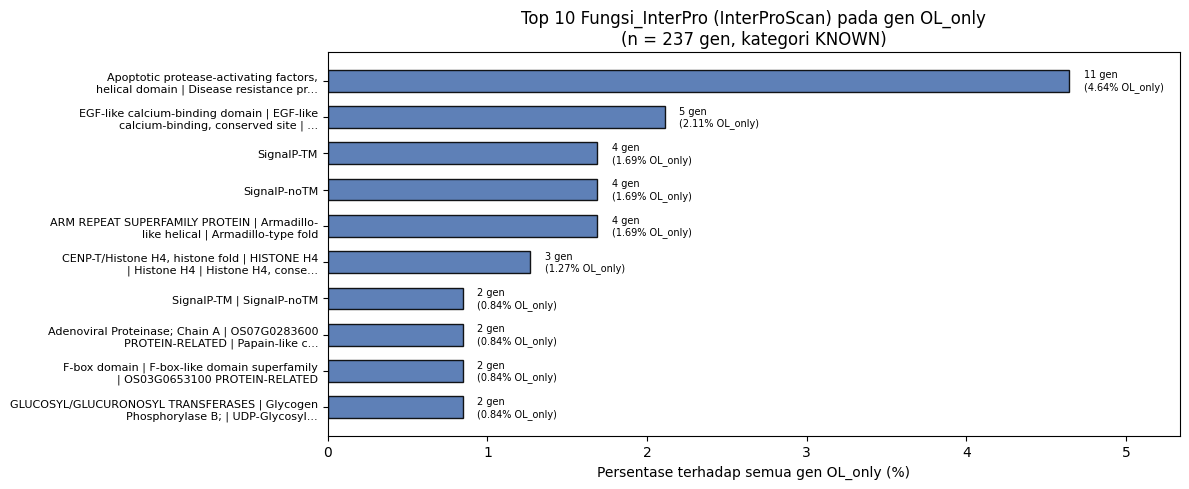

  ✓ Excel tersimpan : D:\result\output_bio\figures_block4\Block4_OL_only_Top10_Fungsi_InterPro_KNOWN_Genes_v21.xlsx
BLOK 4 FINAL v21 COMPLETE
Gambar & tabel tersimpan di: D:\result\output_bio\figures_block4


In [3]:
# =============================================================================
# BLOK 4 FINAL v21 - VISUALISASI, TOP-10 & FUNGSI DOMINAN PER Sumber_Gen
# (kategori KNOWN/UNKNOWN + heatmap tanpa garis putih + barplot Top-10)
# =============================================================================

import os
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0. KONFIGURASI DASAR
# =========================

INPUT_TSV  = r"D:\result\output_bio\PR25_Final_Table_for_TA.tsv"
OUTPUT_DIR = r"D:\result\output_bio\figures_block4"
DATA_DIR   = os.path.join(OUTPUT_DIR, "data_for_figs")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

SAVE_FIG = True  # kalau False → hanya tampil di notebook

# WARNA KONSISTEN
COLOR_RD23 = "#FF6F61"   # merah salmon
COLOR_OL   = "#4C72B0"   # biru
COLOR_BOTH = "#55A868"   # hijau
COLOR_PR25 = "#E0A422"   # kuning

GROUP_ORDER = ["RD23_only", "OL_only", "BOTH"]

# supaya heatmap tidak punya garis kecil antar sel
plt.rcParams["image.interpolation"] = "nearest"

# ============================================================================
# 1. HELPER: TEKS / LABEL
# ============================================================================

def wrap_label(text, width=30):
    """
    Membungkus label panjang agar tidak keluar gambar.
    Dipakai untuk nama fungsi (InterPro/EggNOG/Fungsi_Utama) di sumbu Y.
    """
    return "\n".join(textwrap.wrap(str(text), width=width))


def format_func_label(text, max_len=80, wrap_width=45):
    """
    Memendekkan dan membungkus label fungsi untuk barplot Top-10 per kelompok.
    """
    if pd.isna(text):
        t = ""
    else:
        t = str(text).strip()

    if len(t) > max_len:
        t = t[: max_len - 3] + "..."

    wrapped = textwrap.wrap(t, width=wrap_width)
    return "\n".join(wrapped) if wrapped else t


def _finalize_figure(outfile=None, show=True):
    plt.tight_layout()
    if SAVE_FIG and outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"  ✓ Saved: {outfile}")
    if show:
        plt.show()
    plt.close()


def safe_to_excel(df: pd.DataFrame, path: str) -> None:
    """
    Menyimpan DataFrame ke Excel, tapi kalau file sedang terbuka
    tidak menghentikan eksekusi (hanya memberi peringatan).
    """
    try:
        df.to_excel(path, index=False)
        print(f"  ✓ Excel tersimpan : {path}")
    except PermissionError:
        print(f" Peringatan: berkas tidak dapat ditulis (mungkin sedang dibuka):")
        print(f"               {path}")

# ============================================================================
# 2. LOAD DATA & CHECK KOMPONEN WAJIB
# ============================================================================

print("=" * 76)
print("BLOK 4 FINAL v21 - VISUALISASI, TOP-10 & FUNGSI DOMINAN PER Sumber_Gen")
print("=" * 76)

df = pd.read_csv(INPUT_TSV, sep="\t")
print(f"✓ Data loaded: {len(df):,} genes\n")

required_cols = [
    "Sumber_Gen",
    "Fungsi_Utama",
    "Fungsi_EggNOG",
    "Fungsi_InterPro"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise SystemExit(f"Kolom berikut belum ada di tabel input: {missing}")

# ============================================================================
# 3. DONUT DISTRIBUSI GEN TURUNAN (Sumber_Gen)
# ============================================================================

print("=" * 76)
print("FIGURE 1: Donut Distribusi Gen Turunan (Sumber_Gen)")
print("=" * 76)

sumber_counts = df["Sumber_Gen"].value_counts().reindex(["BOTH", "RD23_only", "OL_only"])
print(sumber_counts, "\n")

labels = ["BOTH", "RD23_only", "OL_only"]
sizes  = [sumber_counts.get("BOTH", 0),
          sumber_counts.get("RD23_only", 0),
          sumber_counts.get("OL_only", 0)]

colors = [COLOR_BOTH, COLOR_RD23, COLOR_OL]

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    colors=colors,
    startangle=90,
    pctdistance=0.82,
    wedgeprops=dict(width=0.3, edgecolor="white"),
    autopct="%.1f%%"
)

total_genes = sum(sizes)
ax.text(0, 0.05, f"{total_genes:,}", ha="center", va="center",
        fontsize=28, fontweight="bold")
ax.text(0, -0.12, "Total Genes", ha="center", va="center",
        fontsize=13)

ax.set_title(
    "Distribusi Gen Turunan pada PR25\n(Sumber_Gen: RD23_only, OL_only, BOTH)",
    fontsize=16
)

legend_labels = []
for lab, val in zip(labels, sizes):
    pct = 100 * val / total_genes if total_genes > 0 else 0
    legend_labels.append(f"{lab}\n({val:,} gen, {pct:.1f}%)")

ax.legend(
    wedges,
    legend_labels,
    title="Kelompok Sumber_Gen",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False
)

out_donut = os.path.join(OUTPUT_DIR, "01_donut_SumberGen_v21.png")
_finalize_figure(out_donut)

# ============================================================================
# 4. EXPORT: DAFTAR GEN PER Sumber_Gen
# ============================================================================

print("=" * 76)
print("EXPORT 1: Daftar gen per Sumber_Gen ke Excel")
print("=" * 76)

genes_by_group_path = os.path.join(OUTPUT_DIR, "Block4_Genes_by_SumberGen_v21.xlsx")
try:
    with pd.ExcelWriter(genes_by_group_path) as xw:
        for group in ["BOTH", "RD23_only", "OL_only"]:
            sub = df[df["Sumber_Gen"] == group].copy()
            sub.to_excel(xw, sheet_name=group, index=False)
    print(f"✓ Excel EXPORT 1 disimpan ke: {genes_by_group_path}\n")
except PermissionError:
    print(" Peringatan: file EXPORT 1 sedang dibuka, tidak bisa ditimpa.\n")

# ============================================================================
# 5. DEFINISI KNOWN vs UNKNOWN (SAMA DENGAN BLOK 3)
# ============================================================================

UNK_KEYWORDS = [
    "uncharacterized",
    "uncharacterised",
    "unknown function",
    "protein of unknown function",
    "domain of unknown function",
    "hypothetical protein"
]

def is_unknown_desc(text: str) -> bool:
    """True -> fungsi UNKNOWN, False -> fungsi KNOWN."""
    if pd.isna(text):
        return True

    t = str(text).strip().lower()
    if t == "":
        return True

    if t in {"unknown", "unknown function"}:
        return True

    return any(k in t for k in UNK_KEYWORDS)

# Flag ini HANYA membaca kolom hasil BLOK 3
df["is_known_Fungsi_Utama"]    = ~df["Fungsi_Utama"].apply(is_unknown_desc)
df["is_known_Fungsi_EggNOG"]   = ~df["Fungsi_EggNOG"].apply(is_unknown_desc)
df["is_known_Fungsi_InterPro"] = ~df["Fungsi_InterPro"].apply(is_unknown_desc)

# ============================================================================
# 6. EXPORT TABEL KNOWN/UNKNOWN + RINGKASAN PERSENTASE
# ============================================================================

known_dir = os.path.join(OUTPUT_DIR, "known_unknown_tables")
os.makedirs(known_dir, exist_ok=True)

def export_known_unknown(df, func_col, known_flag_col, label):
    """
    Membuat:
      - Excel khusus KNOWN & UNKNOWN
      - ringkasan n_known/n_unknown per Sumber_Gen
    Mengembalikan df_known & summary (DataFrame).
    """
    df_known   = df[df[known_flag_col]].copy()
    df_unknown = df[~df[known_flag_col]].copy()

    path_known   = os.path.join(known_dir, f"Block4_{label}_KNOWN_only_v21.xlsx")
    path_unknown = os.path.join(known_dir, f"Block4_{label}_UNKNOWN_only_v21.xlsx")

    safe_to_excel(df_known,   path_known)
    safe_to_excel(df_unknown, path_unknown)

    # ringkasan KNOWN / UNKNOWN per Sumber_Gen
    summary = (
        df.groupby("Sumber_Gen")[known_flag_col]
          .value_counts(dropna=False)
          .unstack(fill_value=0)
    )

    # pastikan ada kolom True dan False
    for col in [True, False]:
        if col not in summary.columns:
            summary[col] = 0

    summary = summary.reindex(columns=[True, False], fill_value=0)
    summary.columns = ["n_known", "n_unknown"]
    summary["total"] = summary["n_known"] + summary["n_unknown"]
    summary["pct_known"]   = summary["n_known"]   / summary["total"] * 100
    summary["pct_unknown"] = summary["n_unknown"] / summary["total"] * 100

    print(f"\nRingkasan KNOWN/UNKNOWN untuk {label}:")
    print(summary.round(2), "\n")

    summary_path = os.path.join(known_dir, f"Block4_{label}_KNOWN_UNKNOWN_summary_v21.csv")
    summary.to_csv(summary_path)
    print(f"  ✓ Ringkasan disimpan ke: {summary_path}\n")

    return df_known, summary

print("=" * 76)
print("EXPORT 2: Tabel KNOWN/UNKNOWN & ringkasan persen")
print("=" * 76)

df_fu_known, fu_summary   = export_known_unknown(df, "Fungsi_Utama",
                                                 "is_known_Fungsi_Utama",
                                                 "FungsiUtama")
df_egg_known, egg_summary = export_known_unknown(df, "Fungsi_EggNOG",
                                                 "is_known_Fungsi_EggNOG",
                                                 "EggNOG")
df_ipr_known, ipr_summary = export_known_unknown(df, "Fungsi_InterPro",
                                                 "is_known_Fungsi_InterPro",
                                                 "InterPro")

# ============================================================================
# 7. HELPER: TOP-10 SUMMARY UNTUK HEATMAP (kategori KNOWN)
# ============================================================================

def build_top10_summary(df_src, func_col, top_n=10):
    """
    df_src : dataframe yang SUDAH difilter hanya gen KNOWN.
    Menghasilkan:
      - pivot_n  : [fungsi x kelompok] berisi n
      - pivot_pct: [fungsi x kelompok] berisi %
      - group_sizes_all: Seri ukuran tiap kelompok, termasuk PR25_all
    """
    if df_src.empty:
        raise ValueError("Dataframe kosong untuk fungsi: " + func_col)

    group_sizes = (
        df_src["Sumber_Gen"]
        .value_counts()
        .reindex(GROUP_ORDER)
        .fillna(0)
        .astype(int)
    )

    counts = (
        df_src
        .groupby([func_col, "Sumber_Gen"])
        .size()
        .reset_index(name="n")
    )

    func_totals = (
        counts.groupby(func_col)["n"]
        .sum()
        .sort_values(ascending=False)
    )
    top_funcs = func_totals.head(top_n).index

    counts_top = counts[counts[func_col].isin(top_funcs)].copy()

    pivot_n3 = (
        counts_top
        .pivot(index=func_col, columns="Sumber_Gen", values="n")
        .reindex(index=top_funcs, columns=GROUP_ORDER)
        .fillna(0)
        .astype(int)
    )

    pivot_n = pivot_n3.copy()
    pivot_n["PR25_all"] = pivot_n3.sum(axis=1)

    pivot_pct = pd.DataFrame(index=pivot_n.index,
                             columns=pivot_n.columns,
                             dtype=float)

    for g in GROUP_ORDER:
        denom = group_sizes[g]
        if denom > 0:
            pivot_pct[g] = pivot_n[g] / denom * 100.0
        else:
            pivot_pct[g] = 0.0

    total_all = float(len(df_src))
    if total_all > 0:
        pivot_pct["PR25_all"] = pivot_n["PR25_all"] / total_all * 100.0
    else:
        pivot_pct["PR25_all"] = 0.0

    group_sizes_all = group_sizes.copy()
    group_sizes_all["PR25_all"] = len(df_src)

    return pivot_n, pivot_pct, group_sizes_all

def plot_top10_heatmap(pivot_n, pivot_pct, group_sizes, title, outfile):
    """
    Heatmap memakai pcolormesh (bukan imshow) supaya tidak muncul garis putih
    di antara sel. Label fungsi diberi tanda '-' di depan.
    """
    funcs  = list(pivot_n.index)
    groups = list(pivot_n.columns)

    data = pivot_pct.values
    n_rows = len(funcs)
    n_cols = len(groups)

    # tinggi fig dinamis (±0.7 inch per baris, min 6 inch)
    fig_height = max(6.0, 0.7 * n_rows)
    fig, ax = plt.subplots(figsize=(12, fig_height))

    # koordinat grid untuk pcolormesh
    x = np.arange(n_cols + 1)
    y = np.arange(n_rows + 1)

    im = ax.pcolormesh(
        x, y, data,
        cmap="YlGnBu",
        vmin=0,
        edgecolors="face",   # supaya tidak ada garis antar sel
        shading="auto"
    )

    # sumbu dibalik (baris 0 di atas)
    ax.set_ylim(n_rows, 0)

    # label sumbu Y (fungsi) + tanda '-'
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels([f"- {wrap_label(f, 30)}" for f in funcs], fontsize=8)

    # label sumbu X (kelompok)
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels(
        [f"{g}\n(n={group_sizes[g]:,})" for g in groups],
        fontsize=9
    )

    ax.set_xlabel("Kelompok Sumber_Gen")
    ax.set_ylabel("Fungsi (Top 10, kategori KNOWN)")
    ax.set_title(title)

    vmax = np.nanmax(data) if np.isfinite(data).any() else 0
    threshold = vmax / 2.0 if vmax > 0 else 0

    # teks di dalam sel (n + persentase)
    for i, func in enumerate(funcs):
        for j, grp in enumerate(groups):
            n   = int(pivot_n.iloc[i, j])
            pct = float(pivot_pct.iloc[i, j])

            text = f"{n}\n({pct:.2f}%)"
            color = "white" if data[i, j] >= threshold else "black"

            ax.text(
                j + 0.5, i + 0.5,
                text,
                ha="center", va="center",
                fontsize=7,
                color=color,
                linespacing=1.2
            )

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Persentase gen dalam setiap kelompok (%)")

    _finalize_figure(os.path.join(OUTPUT_DIR, outfile))

# ============================================================================
# 8. HEATMAP TOP-10 (Fungsi_Utama / EggNOG / InterPro, kategori KNOWN)
# ============================================================================

print("=" * 76)
print("FIGURE: Heatmap Top 10 Fungsi (kategori KNOWN)")
print("=" * 76)

pivot_fu_n, pivot_fu_pct, fu_group_sizes = build_top10_summary(
    df_fu_known, "Fungsi_Utama", top_n=10
)
pivot_fu_n.to_csv(os.path.join(DATA_DIR, "Top10_FungsiUtama_KNOWN_counts_v21.csv"))
pivot_fu_pct.to_csv(os.path.join(DATA_DIR, "Top10_FungsiUtama_KNOWN_pct_v21.csv"))

plot_top10_heatmap(
    pivot_fu_n, pivot_fu_pct, fu_group_sizes,
    title="Top 10 Fungsi_Utama pada gen PR25 (kategori KNOWN)\n"
          "Jumlah dan persentase gen per kelompok Sumber_Gen",
    outfile="20_heatmap_Top10_FungsiUtama_KNOWN_v21.png"
)

pivot_egg_n, pivot_egg_pct, egg_group_sizes = build_top10_summary(
    df_egg_known, "Fungsi_EggNOG", top_n=10
)
pivot_egg_n.to_csv(os.path.join(DATA_DIR, "Top10_FungsiEggNOG_KNOWN_counts_v21.csv"))
pivot_egg_pct.to_csv(os.path.join(DATA_DIR, "Top10_FungsiEggNOG_KNOWN_pct_v21.csv"))

plot_top10_heatmap(
    pivot_egg_n, pivot_egg_pct, egg_group_sizes,
    title="Top 10 Fungsi_EggNOG (EggNOG-mapper) pada gen PR25 (kategori KNOWN)\n"
          "Jumlah dan persentase gen per kelompok Sumber_Gen",
    outfile="21_heatmap_Top10_FungsiEggNOG_KNOWN_v21.png"
)

pivot_ipr_n, pivot_ipr_pct, ipr_group_sizes = build_top10_summary(
    df_ipr_known, "Fungsi_InterPro", top_n=10
)
pivot_ipr_n.to_csv(os.path.join(DATA_DIR, "Top10_FungsiInterPro_KNOWN_counts_v21.csv"))
pivot_ipr_pct.to_csv(os.path.join(DATA_DIR, "Top10_FungsiInterPro_KNOWN_pct_v21.csv"))

plot_top10_heatmap(
    pivot_ipr_n, pivot_ipr_pct, ipr_group_sizes,
    title="Top 10 Fungsi_InterPro (InterProScan) pada gen PR25 (kategori KNOWN)\n"
          "Jumlah dan persentase gen per kelompok Sumber_Gen",
    outfile="22_heatmap_Top10_FungsiInterPro_KNOWN_v21.png"
)

# ============================================================================
# 9. BARPLOT TOP-10 PER KELOMPOK (BOTH, RD23_only, OL_only, kategori KNOWN)
# ============================================================================

def plot_top10_single_group(df_src, group, func_col, func_label,
                            prefix, color, export_excel_path=None):
    """
    Barplot horizontal Top-10 fungsi pada satu kelompok Sumber_Gen (kategori KNOWN)
    dengan label fungsi yang sudah dipendekkan dan dibungkus.
    """
    sub = df_src[df_src["Sumber_Gen"] == group].copy()
    if sub.empty:
        print(f"⚠️ Tidak ada data KNOWN untuk {func_label} di kelompok {group}")
        return

    total = len(sub)
    counts = sub[func_col].value_counts().head(10)
    order  = counts.index[::-1]   # bar terbesar di atas

    n_vals   = counts.reindex(order)
    pct_vals = n_vals / total * 100.0

    # tinggi figure dinamis
    n_bars     = len(order)
    fig_height = max(4.0, 0.5 * n_bars)
    fig, ax = plt.subplots(figsize=(12, fig_height))

    y_pos = np.arange(n_bars)

    ax.barh(y_pos, pct_vals.values,
            color=color, edgecolor="black", alpha=0.9, height=0.6)

    y_labels = [format_func_label(f, max_len=80, wrap_width=45) for f in order]
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels, fontsize=8)

    ax.set_xlabel(f"Persentase terhadap semua gen {group} (%)")
    ax.set_title(
        f"Top 10 {func_label} pada gen {group}\n"
        f"(n = {total:,} gen, kategori KNOWN)"
    )

    max_pct = pct_vals.max()
    ax.set_xlim(0, max_pct * 1.15 if max_pct > 0 else 1)

    for i, (n, pct) in enumerate(zip(n_vals.values, pct_vals.values)):
        ax.text(
            pct + max_pct * 0.02,
            i,
            f"{n} gen\n({pct:.2f}% {group})",
            va="center",
            fontsize=7,
        )

    outfile = os.path.join(OUTPUT_DIR, f"{prefix}_{group}_v21.png")
    _finalize_figure(outfile)

    if export_excel_path is not None:
        df_list = []
        for func in order:
            df_func = sub[sub[func_col] == func].copy()
            df_func["__Top_Function__"] = func
            df_list.append(df_func)
        df_out = pd.concat(df_list, ignore_index=True)
        safe_to_excel(df_out, export_excel_path)

print("=" * 76)
print("FIGURE: Top-10 per kelompok (kategori KNOWN)")
print("=" * 76)

for grp in ["BOTH", "RD23_only", "OL_only"]:
    excel_path = None
    if grp == "OL_only":
        excel_path = os.path.join(
            OUTPUT_DIR,
            "Block4_OL_only_Top10_Fungsi_Utama_KNOWN_Genes_v21.xlsx"
        )
    plot_top10_single_group(
        df_fu_known, grp,
        func_col="Fungsi_Utama",
        func_label="Fungsi_Utama (InterPro + EggNOG)",
        prefix="23_Top10_FungsiUtama",
        color=COLOR_BOTH if grp == "BOTH" else (COLOR_RD23 if grp == "RD23_only" else COLOR_OL),
        export_excel_path=excel_path
    )

for grp in ["BOTH", "RD23_only", "OL_only"]:
    excel_path = None
    if grp == "OL_only":
        excel_path = os.path.join(
            OUTPUT_DIR,
            "Block4_OL_only_Top10_Fungsi_EggNOG_KNOWN_Genes_v21.xlsx"
        )
    plot_top10_single_group(
        df_egg_known, grp,
        func_col="Fungsi_EggNOG",
        func_label="Fungsi_EggNOG (EggNOG-mapper)",
        prefix="24_Top10_FungsiEggNOG",
        color=COLOR_BOTH if grp == "BOTH" else (COLOR_RD23 if grp == "RD23_only" else COLOR_OL),
        export_excel_path=excel_path
    )

for grp in ["BOTH", "RD23_only", "OL_only"]:
    excel_path = None
    if grp == "OL_only":
        excel_path = os.path.join(
            OUTPUT_DIR,
            "Block4_OL_only_Top10_Fungsi_InterPro_KNOWN_Genes_v21.xlsx"
        )
    plot_top10_single_group(
        df_ipr_known, grp,
        func_col="Fungsi_InterPro",
        func_label="Fungsi_InterPro (InterProScan)",
        prefix="25_Top10_FungsiInterPro",
        color=COLOR_BOTH if grp == "BOTH" else (COLOR_RD23 if grp == "RD23_only" else COLOR_OL),
        export_excel_path=excel_path
    )

print("=" * 76)
print("BLOK 4 FINAL v21 COMPLETE")
print("=" * 76)
print(f"Gambar & tabel tersimpan di: {OUTPUT_DIR}")
